In [4]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)
import os

# Números y Datos
import numpy as np
import pandas as pd
#%pip install python-louvain
import community.community_louvain as cl
import networkx as nx

from glob import glob
from pathlib import Path
from scipy import stats
from scipy.stats import ranksums

from sklearn.metrics import adjusted_rand_score
from itertools import permutations

## Bajamos datos
### Primero datos de sujetos

In [ ]:
# !wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
# !unzip -q DataSujetos
# !wget -O aal_extended_withCoords.csv https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1


--2023-12-10 20:17:37--  https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe456afba28f292d20898198d2.dl.dropboxusercontent.com/cd/0/inline/CJJ4JHyqpeHnxWC1ydVkvTS9E1JPqSfvOBqlSgMjYJnL1OOKX5Pd4h_R1JrSUZmHuVskv8vbSvAMlVNIz_VnU0MAo_GDBO5a3Aho7eb2XSO8G_TtlbRVKM6Tqn7vUaPl8NxM5cHqpAslCfm9vgkGu27o/file# [following]
--2023-12-10 20:17:40--  https://ucbe456afba28f292d20898198d2.dl.dropboxusercontent.com/cd/0/inline/CJJ4JHyqpeHnxWC1ydVkvTS9E1JPqSfvOBqlSgMjYJnL1OOKX5Pd4h_R1JrSUZmHuVskv8vbSvAMlVNIz_VnU0MAo_GDBO5a3Aho7eb2XSO8G_TtlbRVKM6Tqn7vUaPl8NxM5cHqpAslCfm9vgkGu27o/file
Resolving ucbe456afba28f292d20898198d2.dl.dropboxusercontent.com (ucbe456afba28f292d20898198d2.dl.dropboxusercontent.com)... 162.1

## Luego atlas
### Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecham, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [5]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames

1     2          3   4   5   6   7
0         Precentral_L  2001    Central   L -39  -6  51
1         Precentral_R  2002    Central   R  41  -8  52
2        Frontal_Sup_L  2101    Frontal   L -18  35  42
3        Frontal_Sup_R  2102    Frontal   R  22  31  44
4    Frontal_Sup_Orb_L  2111    Frontal   L -17  47 -13
..                 ...   ...        ...  ..  ..  ..  ..
111           Vermis_6  9130  Cerebelum  --   2 -67 -15
112           Vermis_7  9140  Cerebelum  --   2 -72 -25
113           Vermis_8  9150  Cerebelum  --   2 -64 -34
114           Vermis_9  9160  Cerebelum  --   2 -55 -35
115          Vermis_10  9170  Cerebelum  --   1 -46 -32

[116 rows x 7 columns]

## Lista de archivos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

# TP 2

## Tarea 1: Visualización

Para cada estadío del sueño (despierto -W - y N 1, N 2, N 3) calcular el promedio entre sujetos de la matriz de correlaciones entre regiones cerebrales. Interpretaremos las matrices resultantes como la matriz de adyacencia pesada de un grafo donde los nodos son regiones cerebrales, para cada estadío del sueño. Visualizar dichas matrices. Vamos a definir un parámetro δ que represente la densidad de enlaces, y en este TP lo haremos variar entre 0 y 0.15 (valores de densidad de enlances fisiológicamante “realistas”). Con este parámetro δ podremos generar grafos binarios con la densidad de enlaces desada.

In [13]:
files = os.listdir('DataSujetos/')
sujetos = pd.DataFrame(files)
sujetos['estado'] = sujetos[0].apply(lambda x:x.split('_')[0])
sujetos['sujeto'] = sujetos[0].apply(lambda x:x.split('_')[1].split('.')[0])
sujetos['sujeto'] = sujetos['sujeto'].str.replace(repl='',pat='suj').astype('object')
sujetos.rename(columns={0:'path'},inplace=True)
sujetos.set_index('path',inplace=True)
sujetos.head()

estado sujeto
path                      
N1_suj1.csv      N1      1
N1_suj10.csv     N1     10
N1_suj11.csv     N1     11
N1_suj12.csv     N1     12
N1_suj13.csv     N1     13

In [ ]:
pd.read_csv('DataSujetos/W_suj13.csv').shape

(115, 116)

Cambios en la matriz promedio para evitar autoenlaces posteriores en el ploteo de los grafos

In [8]:
def matriz_promedio(condicion):
  files = sujetos.index[sujetos.index.str.contains(condicion)]
  # promediar matdyacPesada de todos los sujetos
  n=116
  matAdyacPesada_prom = np.zeros((n,n))
  for i in files:
    matAdyacPesada_prom += pd.read_csv('DataSujetos/'+i,header=None).values
    np.fill_diagonal(matAdyacPesada_prom, 0) #0 en la diagonal para que no genere autoenlaces
    matAdyacPesada_prom /= files.shape[0]
  return matAdyacPesada_prom

Mismo grafico anterior de antes, pero colocando en la diagonal 0 y dando vuelta los ejes para que se vea como en el pret2 y en el paper

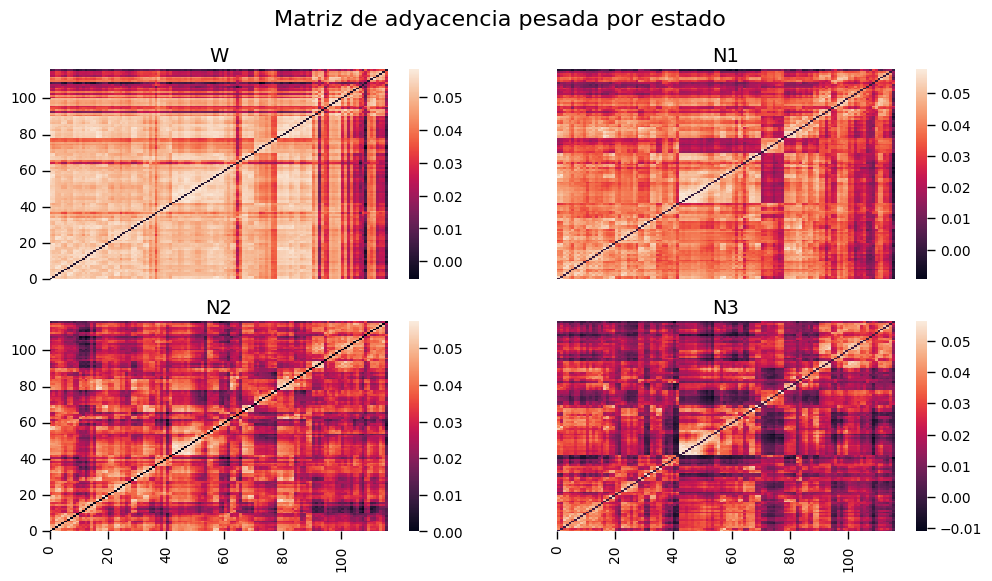

In [ ]:
# Function to create a heatmap for a given estado
def create_heatmap(ax, estado):
    heatmap = sns.heatmap(matriz_promedio(estado), ax=ax, fmt=".3f", annot_kws={"size": 12},
                         #cbar_kws={"shrink": 0.8, "label": "Scale", "orientation": "horizontal", "pad": 0.05}
                          )
    ax.set_title(estado, size=14)
    ax.set_xlim(0, n)
    ax.set_ylim(0, n)

    # Adjust tick spacing here
    tick_spacing = 20  # Set your desired tick spacing
    ax.set_xticks(range(0, n + 1, tick_spacing))
    ax.set_yticks(range(0, n + 1, tick_spacing))
    ax.set_xticklabels(ax.get_xticks(), size=10)  # Adjust x-axis label size
    ax.set_yticklabels(ax.get_yticks(), size=10)  # Adjust y-axis label size

    heatmap.collections[0].colorbar.ax.tick_params(labelsize=10,length=6, width=1)

    ax.tick_params(axis='both', which='both', length=6, width=1)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
estados = ['W', 'N1', 'N2', 'N3']
plt.suptitle('Matriz de adyacencia pesada por estado', size=16)

n = 116
for i, estado in enumerate(estados):
    ax_i = ax[i // 2, i % 2]
    create_heatmap(ax_i, estado)
    if i < 2:
        ax_i.set_xticks([])  # Hide x-axis ticks for the first two plots
    if i % 2 != 0:
        ax_i.set_yticks([])  # Hide y-axis ticks for the second column

# Adjust layout to prevent clipping of titles
#plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.savefig('matriz_promedio.png')
plt.show()


### Primero comparar como varía el tamaño de la componente gigante (es decir, el porcentaje de nodos que participan en la componente gigante) en función de δ, para todos los estadíos. Interpretar las curvas obtenidas. ¿Qué nos indican los saltos?

In [9]:
def density_to_th(W, d):
    n=W.shape[0]
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

In [10]:
def porcentaje(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  # Calcular la componente gigante del grafo
  componente_gigante = max(nx.connected_components(G), key=len)
  # Calcular el porcentaje de nodos que participan en la componente gigante
  return len(componente_gigante) / len(G)

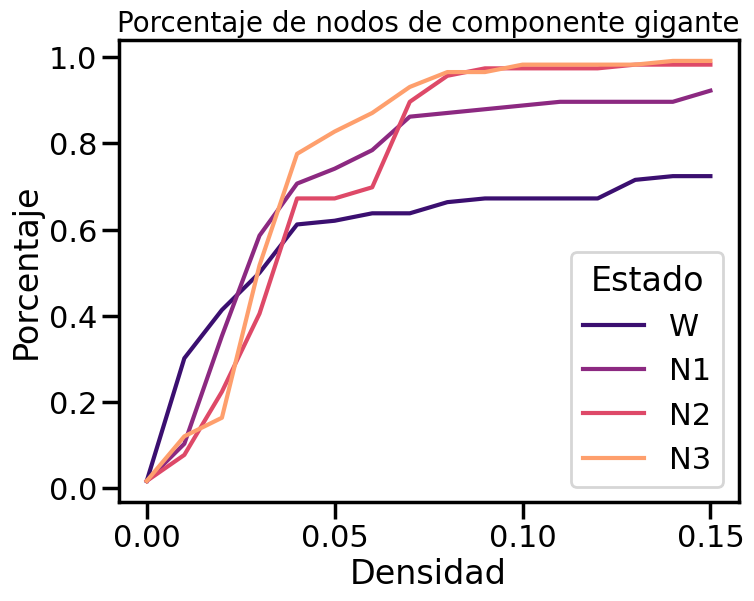

In [ ]:
estados = ['W','N1','N2','N3']
densidades = np.arange(0,0.16,0.01)
porcentajes = pd.DataFrame(index=estados)
color_palette = sns.color_palette('magma', n_colors=len(estados))
plt.title('Porcentaje de nodos de componente gigante',size=20)

for i, estado in enumerate(estados):
    for densidad in densidades:
        porcentajes.loc[estado, densidad] = porcentaje(matriz_promedio(estado), densidad)

    # Plot each state with a color from the palette
    plt.plot(densidades, porcentajes.loc[estado], label=estado, color=color_palette[i])

plt.xlabel('Densidad')
plt.ylabel('Porcentaje')
plt.legend(title='Estado')
plt.savefig('grafo_binarizado.png', bbox_inches = 'tight')
plt.show()

Los saltos en las curvas indica que el componente gigante se conectó con un grafo también grande, lo cual hace que la densidad ascienda abruptamente.

Es el mismo gráfico, cambie un poquito la estética nomas

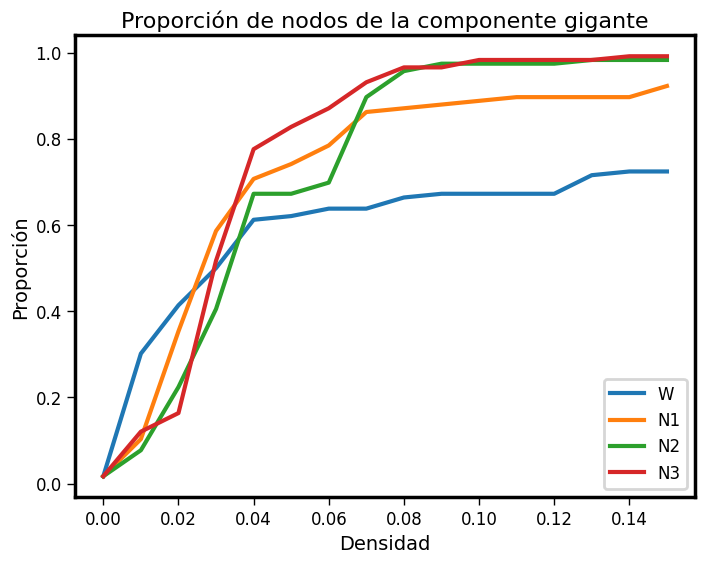

In [ ]:
estados = ['W', 'N1', 'N2', 'N3']
densidades = np.arange(0, 0.16, 0.01)
porcentajes = pd.DataFrame(index=estados)

plt.title('Proporción de nodos de la componente gigante', size=16)

for estado in estados:
    for densidad in densidades:
        porcentajes.loc[estado, densidad] = porcentaje(matriz_promedio(estado), densidad)

    # Change font size of axis labels
    plt.xlabel('Densidad', fontsize=14)
    plt.ylabel('Proporción', fontsize=14)
    plt.tick_params('both', length=6, width=1, labelsize=12)
    porcentajes.loc[estado].plot(legend=estado)

plt.legend(fontsize=12, loc = "lower right")
# Show the plot
plt.show()


La densidad es utilizada como umbral (threshold) para binarizar la matriz de correlación entre las señales BOLD de las 116 regiones cerebrales (matriz pesada). Si la densidad de enlaces aumenta, el umbral (correlación o peso del enlace) disminuye, indicando que existen conexiones entre regiones para valores menores de correlación. Es decir, a mayor densidad de enlaces, más conexiones entre regiones cerebrales, por lo tanto la componente gigante va siendo mayor.
Los estadios W y N3 presentan un aumento muy importante del tamaño de la componente gigante con un aumento de densidad de 0.02 a 0.03.

### Elegir uno de los saltos y visualizar los grafos correspondientes para valores de δ justo antes y justo después del salto. Para esta, y todas las visualizaciones de grafos de este TP, representar siempre a los nodos en sus respectivas coordenadas cerebrales.

In [11]:
def grafo_densidad(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  return G

Al ejececutarlo con la nueva matriz binarizada, debieran desaparecer los autoenlaces

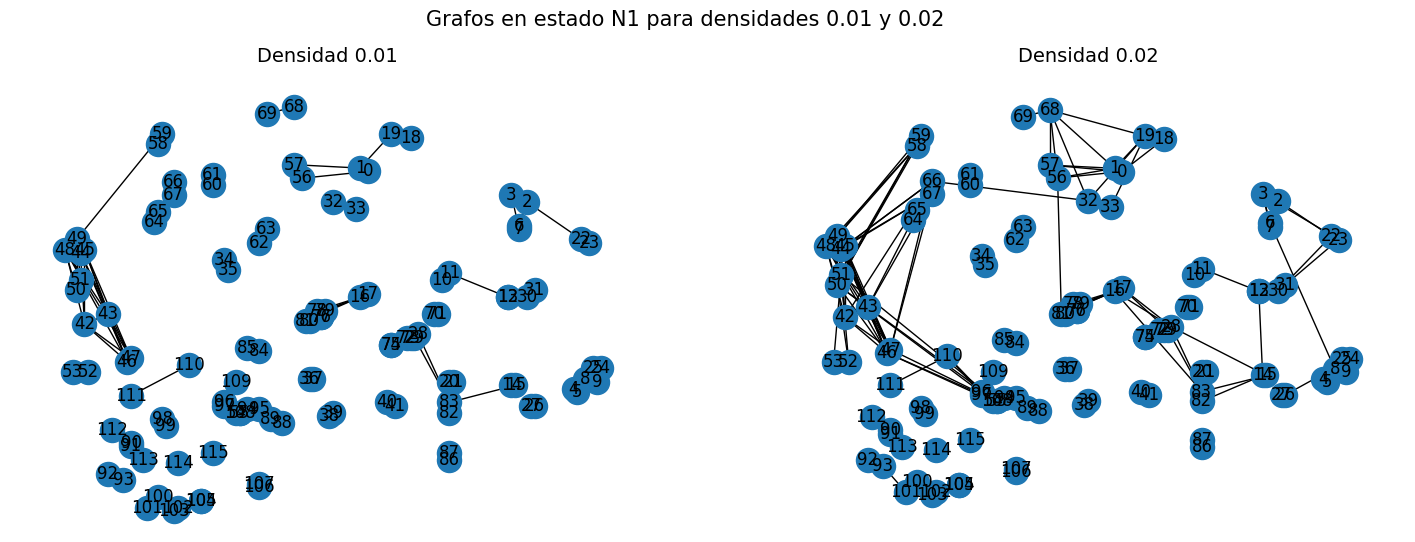

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.01 y 0.02',size=15)
for n,densidad in enumerate([0.01,0.02]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =1,ax=ax[n])
  ax[n].set_title(f'Densidad {densidad}', fontsize=14)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric 

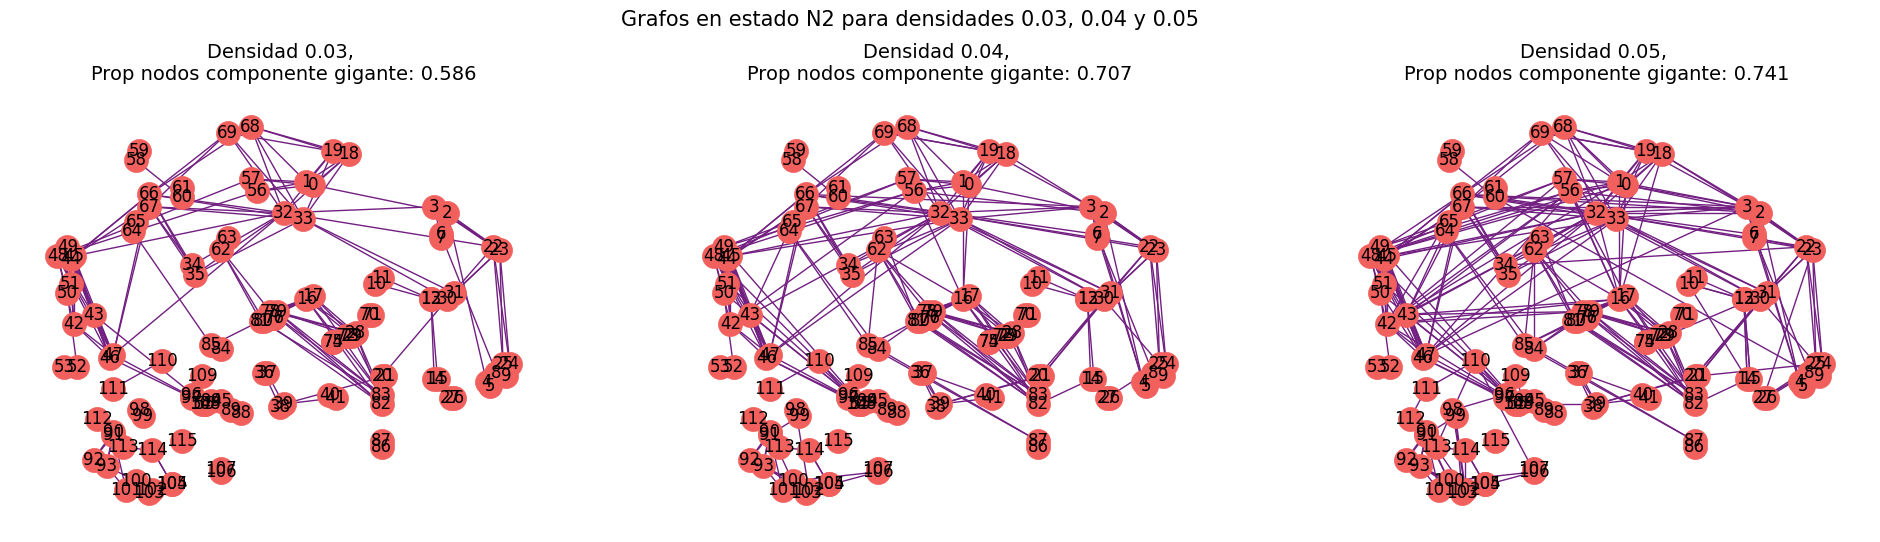

In [ ]:
colores = sns.color_palette('magma', n_colors=2)
fig, ax = plt.subplots(1,3,figsize=(24,6), gridspec_kw={'top': 0.85})
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N2 para densidades 0.03, 0.04 y 0.05',size=15)
for n,densidad in enumerate([0.03,0.04, 0.05]):
  G = grafo_densidad(matriz_promedio('N2'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =0.5,ax=ax[n],node_color = colores[1], edge_color = colores[0])

  porcentajes_value = porcentajes.loc['N1', densidad]
  #ax[n].set_title(f'Densidad {densidad}', fontsize=14)
  ax[n].set_title(f'Densidad {densidad}, \nProp nodos componente gigante: {porcentajes_value:.3}', fontsize=14)

plt.savefig('salto_N2.png',bbox_inches = 'tight')
plt.show()

Se torna muy evidente el aumento en la conectividad de los nodos para el estadio N1 al incrementar la densidad en un 1% de 0.03 a 0.04. La proporción de nodos que participan en la componente gigante pasa del 24% al 60% con dicho incremento de densidad.

### Graficar como varía el grado medio, el coeficiente de clustering medio, y la eficiencia global en función de δ. Interpretar curvas.

In [ ]:
def metricas(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  G = nx.from_numpy_array(matriz_promedio_no_pesada)
  # Calcular el grado de cada nodo
  grados = [G.degree(node) for node in G.nodes()]
  # Calcular el grado medio del grafo
  grado_medio = sum(grados) / len(grados)

  clustering_medio = nx.average_clustering(G)

  eficiencia_global = nx.global_efficiency(G)

  return grado_medio, clustering_medio, eficiencia_global

In [ ]:
metricas_dict = {}

for estado in estados:
  metricas_dict[estado] = pd.DataFrame()
  for densidad in densidades:
    medidas = metricas(matriz_promedio(estado),densidad)
    metricas_dict[estado].loc[densidad,'grado_medio'      ] = medidas[0]
    metricas_dict[estado].loc[densidad,'clustering_medio' ] = medidas[1]
    metricas_dict[estado].loc[densidad,'eficiencia_global'] = medidas[2]

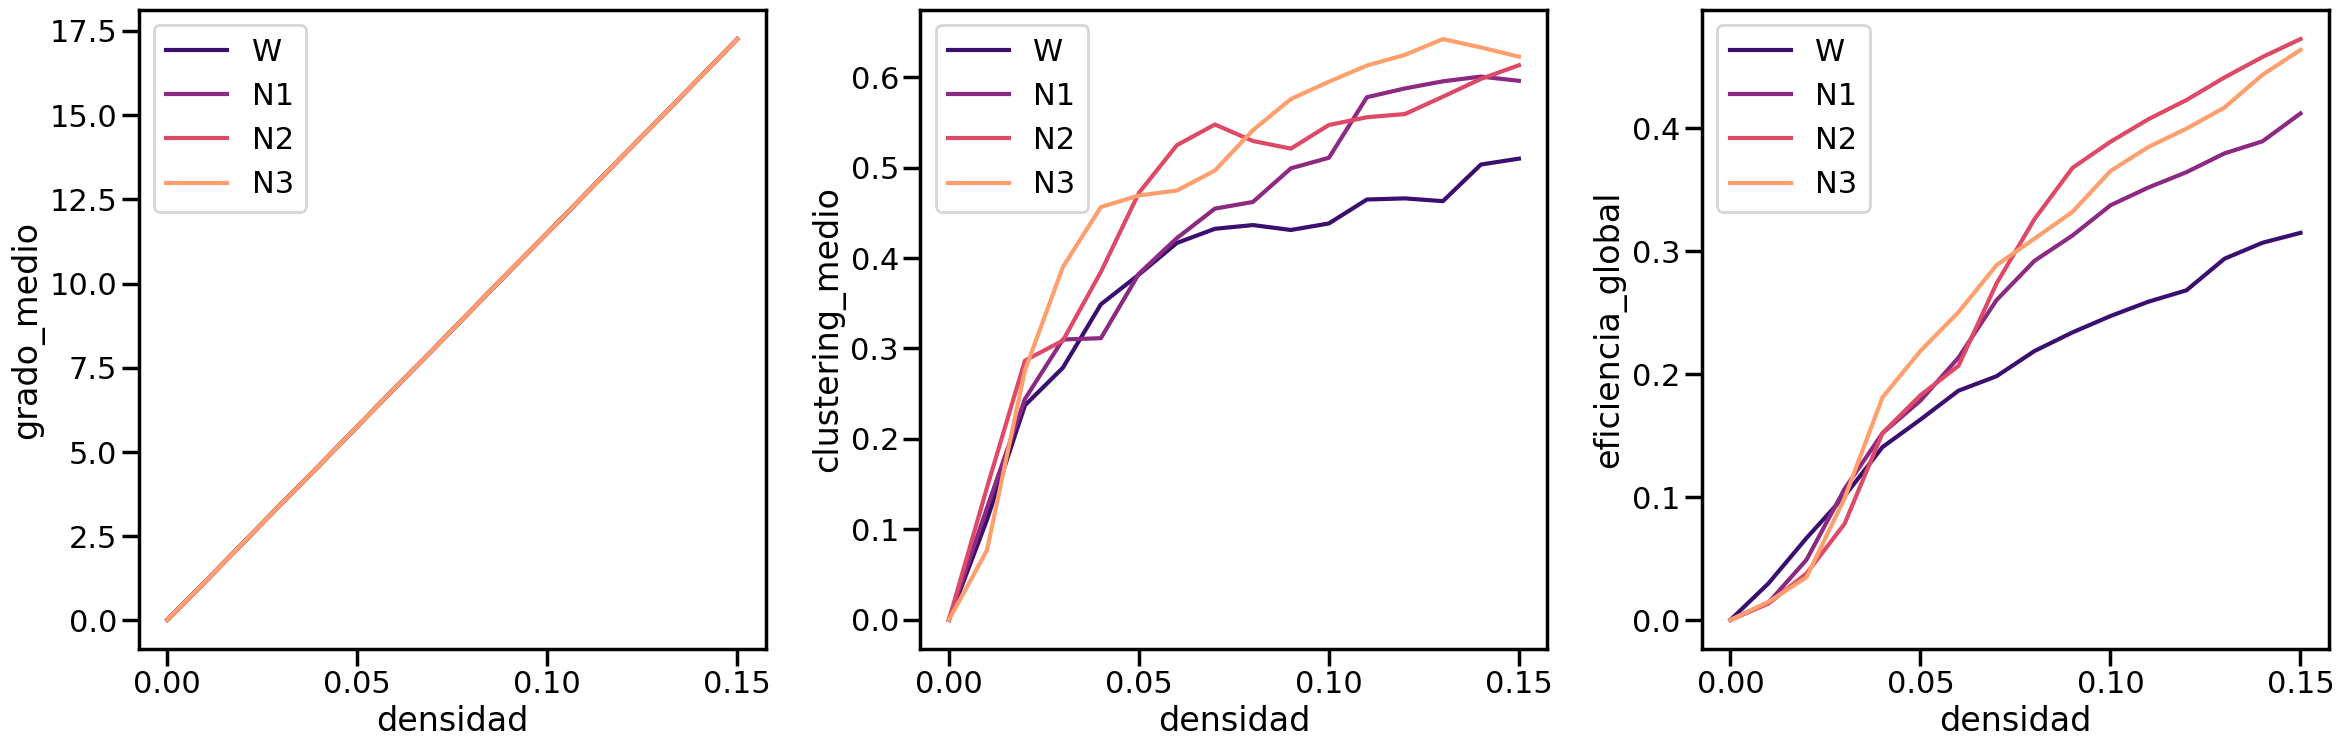

In [ ]:
# Define a seaborn color palette
palette = sns.color_palette('magma', n_colors=len(estados))

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(24, 8))
#plt.suptitle('Metricas según estado y densidad')

for n, metrica in enumerate(['grado_medio', 'clustering_medio', 'eficiencia_global']):
    ax[n].set(xlabel='densidad', ylabel=metrica)

    # Iterate through states and plot each line individually
    for i, estado in enumerate(estados):
        ax[n].plot(metricas_dict[estado][metrica], label=estado, color=palette[i])

    ax[n].legend()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.savefig('metricas.png',bbox_inches = 'tight')
plt.show()


### Para un valor de δ=0.12 visualizar el grafo de cada estadío, donde el color del nodo i esté dado a su centralidad de autovector ceigen i , y su tamaño sea proporcional a αceigen i (donde α es una constante que debemos elegir para ayudar la visualización). ¿Se observan cambios entre estadíos?

Debieran desaparecer los autoenlaces cuando lo ejecuten de nuevo

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


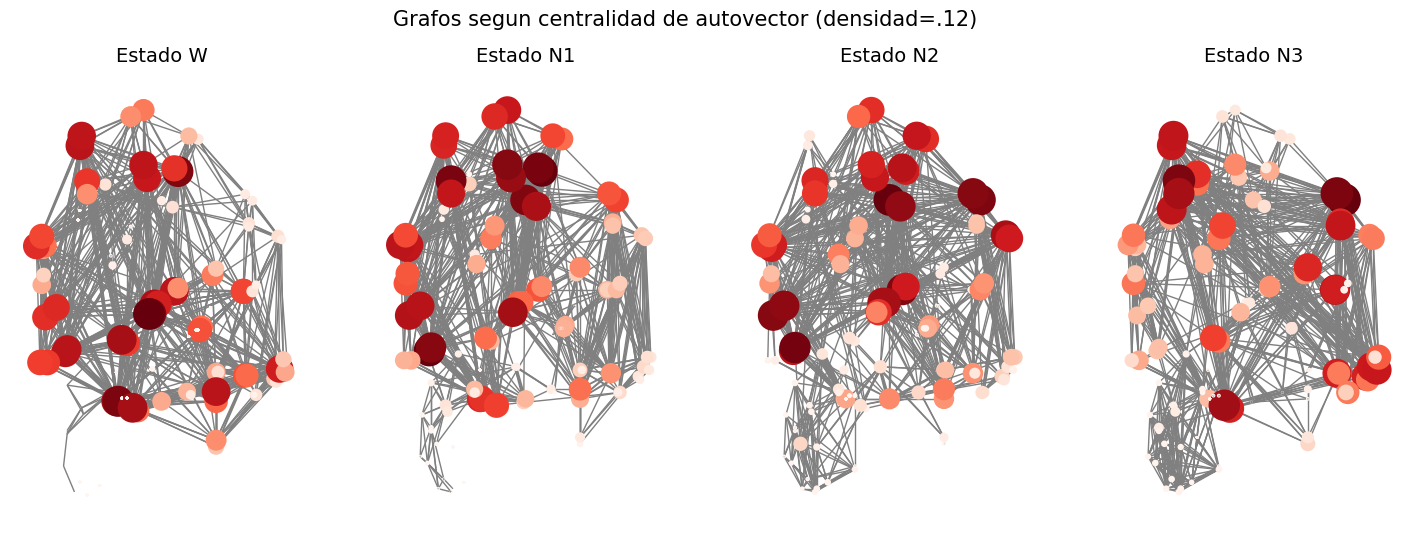

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
alpha = 2000

plt.suptitle('Grafos segun centralidad de autovector (densidad=.12)',size=15)
for n,estado in enumerate(estados):
  G = grafo_densidad(matriz_promedio(estado),.12)
  autovectores = list(nx.eigenvector_centrality_numpy(G).values())
  nx.draw(G,layout, with_labels=False,ax=ax[n],cmap=plt.cm.Reds,
          node_color=autovectores,node_size=[x*alpha for x in autovectores], edge_color='gray')
  ax[n].set_title(f'Estado {estado}', fontsize=14)

Cambio un poco la estetica por si interesa

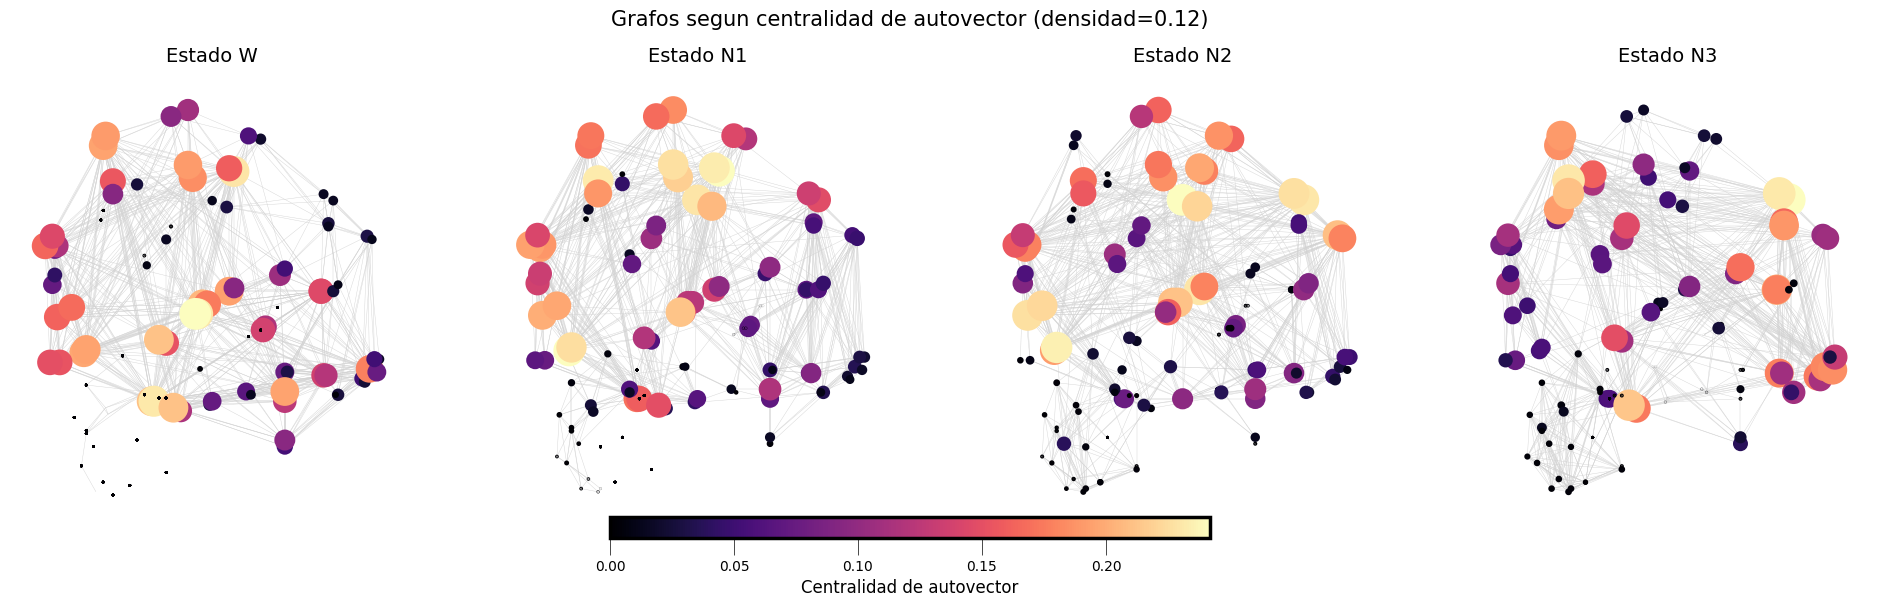

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 4, figsize=(24, 6))
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
alpha = 2000

plt.suptitle('Grafos segun centralidad de autovector (densidad=0.12)', size=15)

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), .12)
    autovectores = np.array(list(nx.eigenvector_centrality_numpy(G).values()))

    # Check for NaN or negative values and replace them with 0
    valid_autovectores = np.where(np.isnan(autovectores) | (autovectores < 0), 0, autovectores)

    # Plot the graph
    node_colors = valid_autovectores
    cmap = sns.color_palette('magma', as_cmap=True)
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Need an empty array for the scalar mappable

    nx.draw(G, layout, with_labels=False, ax=ax[n], cmap=cmap,
            node_color=node_colors, node_size=[x * alpha for x in valid_autovectores], edge_color='lightgray', width=0.3)

    ax[n].set_title(f'Estado {estado}', fontsize=14)

# Add horizontal colorbar with adjusted size and position
cbar_ax = fig.add_axes([0.375, 0.1, 0.25, 0.035])  # Adjust the values [left, bottom, width, height] according to your preference
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Centralidad de autovector', fontsize=12)  # Set the fontsize for the colorbar label
cbar.ax.tick_params(labelsize=10, width=0.5)  # Adjust the fontsize and width of colorbar tick labels
cbar.ax.xaxis.set_tick_params(width=0.5)  # Adjust the width of the colorbar itself

plt.savefig('centralidad_autovector.png', bbox_inches='tight')
plt.show()


#Tarea 2: Comunidades y coeﬁciente de modularidad

Vamos a analizar como varía la modularidad entre los sujetos de cada estadío, en función de δ (como siempre, en el rango δ=0-0.15). De aquí en adelante, siempre que se graﬁquen curvas promedio, se deben graﬁcar con una noción de incerteza (el error estandard de la media)

### 1.

Para cada sujeto de cada estadío generar grafos variando δ, determinar comunidades en dichos grafos a partir de algoritmo de Louvain [Blondel et al., 2008], y calcular la curva que describa el coeﬁciente de modularidad (Q) en función de δ. Promediando entre sujetos de cada estadío, obtener la curva correspondiente a cada estadío. Compararlas con las curvas de Q en función de δ para “modelos nulos” equivalentes: usando grafos random de igual cantidad total de nodos e igual densidad de enlaces δ. Para cada valor de δ incluir un test de signiﬁcancia clásico para diferencias entre el grafo observado y el modelo nulo de grafo azar (marcar con un asterico las comparciones signiﬁcativas). Discutir los resultados.

Agrego el random state a las particiones, y cambio un poquito la estetica del grafico por si sirve

Text(0, 0.5, 'modularidad')

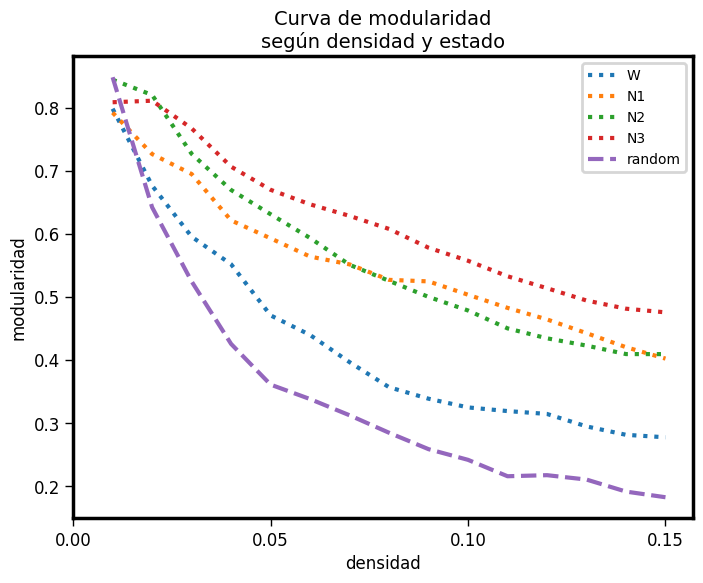

In [ ]:
plt.figure(figsize=(8,6))
modularidades = pd.DataFrame()
for estado in estados:
    for densidad in densidades:
      if densidad != 0: #AGREGO ESTO PARA QUE NO CALCULE PARA LA DENSIDAD ==0
        G = grafo_densidad(matriz_promedio(estado), densidad)
        modulos = cl.best_partition(G, random_state = 42) #FIJO EL RANDOM PARA QUE NO CAMBIEN LAS PARTICIONES
        modularidades.loc[densidad,estado] = cl.modularity(modulos, G)

        if estado=='N3':
            R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
            modulos_R = cl.best_partition(R, random_state = 42) #FIJO EL RANDOM PARA QUE NO CAMBIEN LAS PARTICIONES
            modularidades.loc[densidad,'random'] = cl.modularity(modulos_R, R)

    plt.plot(modularidades[estado], linestyle='dotted',label=estado)


plt.tick_params(axis='both', which='both', length=6, width=1, labelsize = 12)
plt.xticks(np.arange(0, 0.16, 0.05))
plt.xlim(0)


plt.plot(modularidades['random'], linestyle='dashed',label='random')
plt.legend(fontsize = 10)
plt.title('Curva de modularidad\nsegún densidad y estado', size = 14)
plt.xlabel('densidad', size = 12)
plt.ylabel('modularidad', size = 12)

Agrego el random state a las particiones, y cambio un poquito la estetica del grafico por si sirve

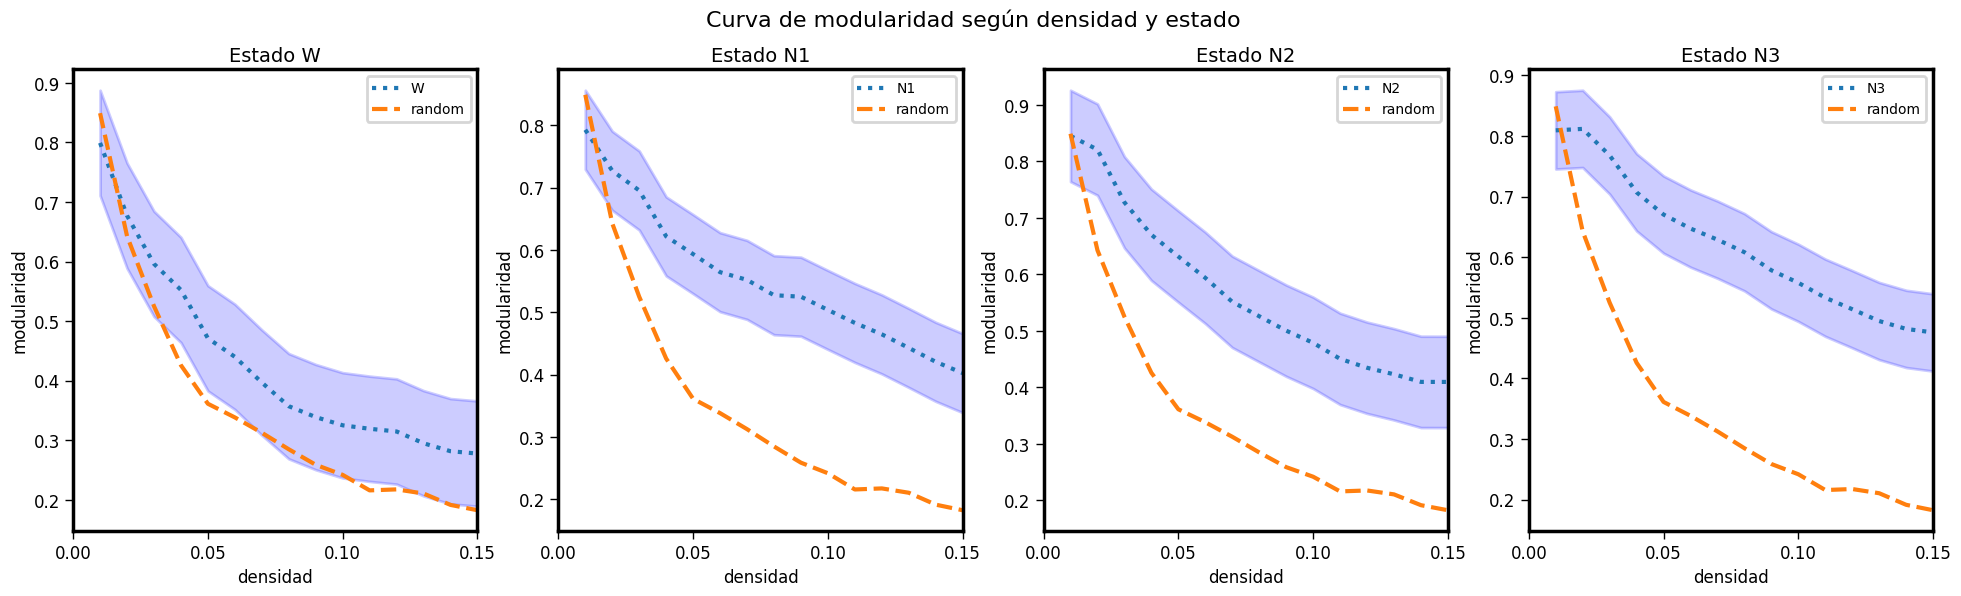

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(24,6))
modularidades = pd.DataFrame()
for n,estado in enumerate(estados):
    for densidad in densidades:
        if densidad!=0:
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G, random_state = 42)
            modularidades.loc[densidad,estado] = cl.modularity(modulos, G)
            if n==0:
                R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
                modulos_R = cl.best_partition(R, random_state = 42)
                modularidades.loc[densidad,'random'] = cl.modularity(modulos_R, R)

    mean_values = modularidades[estado]
    confidence_intervals = [stats.t.interval(0.95, len(mean_values)-1, loc=mean_val, scale=stats.sem(mean_values)) for mean_val in mean_values]

    lower_bounds = [interval[0] for interval in confidence_intervals]
    upper_bounds = [interval[1] for interval in confidence_intervals]

    ax[n].set_xticks(np.arange(0, 0.16, 0.05)) #se puede cambiar si quieren que tenga mas, deje igual que el que tiene todos juntos
    ax[n].set_xlim(0, 0.15)
    ax[n].fill_between(modularidades.index, lower_bounds, upper_bounds, color='blue', alpha=0.2)
    ax[n].plot(modularidades[estado], linestyle='dotted',label=estado)
    ax[n].plot(modularidades['random'], linestyle='dashed',label='random')
    ax[n].set_title(f'Estado {estado}', fontsize=14)
    ax[n].tick_params(axis='both', which='both', length=6, width=1, labelsize = 12)
    ax[n].legend(fontsize = 10)
    ax[n].set_xlabel('densidad', size = 12)
    ax[n].set_ylabel('modularidad', size= 12)
    # if n==0:
    #     ax[n].set_ylabel('modularidad', size= 12)
    # else:
    #     ax[n].set_yticklabels([])

plt.suptitle('Curva de modularidad según densidad y estado', size= 16);

Agrego el random state a las particiones, y cambio un poquito la estetica del grafico por si sirve. Me parece mejor cambiar modularidades = pd.DataFrame() por comunidades= pd.DataFrame() para no pisar con los calculado antes. Y tener el dataframe de modularidades y el de comunidades

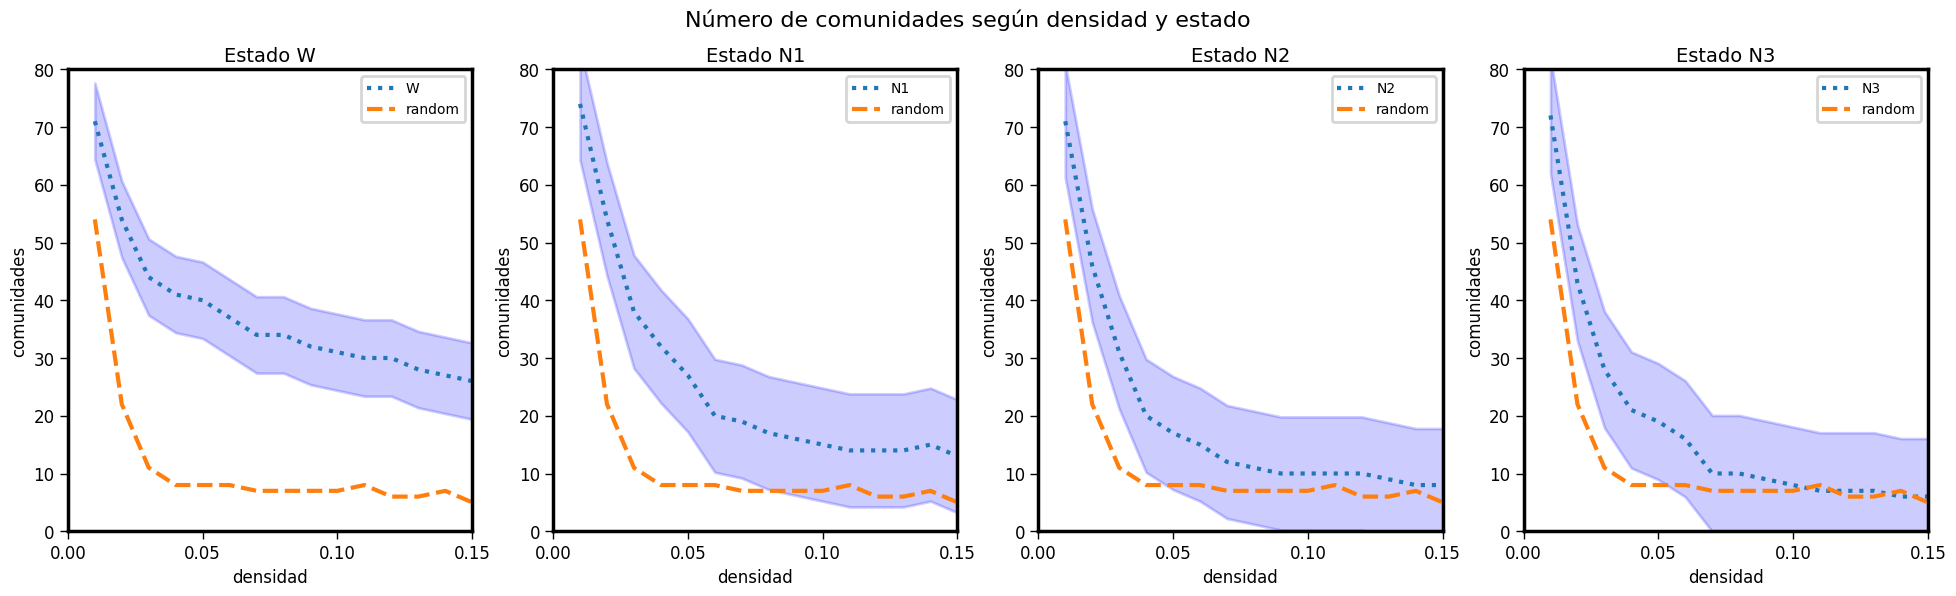

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(24,6))
modularidades = pd.DataFrame()
for n,estado in enumerate(estados):
    for densidad in densidades:
        if densidad!=0:
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G, random_state = 42)
            modularidades.loc[densidad,estado] = len(set(modulos.values()))
            if n==0:
                R = nx.gnm_random_graph(G.number_of_nodes(), G.number_of_edges(),seed=42)
                modulos_R = cl.best_partition(R, random_state = 42)
                modularidades.loc[densidad,'random'] = len(set(modulos_R.values()))

    mean_values = modularidades[estado]
    confidence_intervals = [stats.t.interval(0.95, len(mean_values)-1, loc=mean_val, scale=stats.sem(mean_values)) for mean_val in mean_values]

    lower_bounds = [interval[0] for interval in confidence_intervals]
    upper_bounds = [interval[1] for interval in confidence_intervals]

    ax[n].fill_between(modularidades.index, lower_bounds, upper_bounds, color='blue', alpha=0.2)

    ax[n].set_xticks(np.arange(0, 0.16, 0.05)) #se puede cambiar si quieren que tenga mas, deje igual que el que tiene todos juntos
    ax[n].set_xlim(0, 0.15)
    ax[n].set_ylim(0, 80)
    ax[n].plot(modularidades[estado], linestyle='dotted',label=estado)
    ax[n].plot(modularidades['random'], linestyle='dashed',label='random')
    ax[n].set_title(f'Estado {estado}', fontsize=14)
    ax[n].tick_params(axis='both', which='both', length=6, width=1, labelsize = 12)
    ax[n].legend(fontsize = 10)
    ax[n].set_xlabel('densidad', size =12)
    ax[n].set_ylabel('comunidades', size =12)
    # if n==0:
    #     ax[n].set_ylabel('comunidades')
    # else:
        # ax[n].set_yticklabels([])

plt.suptitle('Número de comunidades según densidad y estado', size = 16);

In [ ]:
sujetos_list = sujetos.index[sujetos.index.str.contains(estado)]
curvas = pd.DataFrame(index=['sujeto','estado','densidad','comunidades','modularidad','comunidades_random','modularidad_random'])
#densidades = np.arange(0.01,0.16,0.01)
densidades = np.linspace(0.005,0.15,num=15)
for estado in estados:
    for densidad in densidades:
        for sujeto in sujetos.loc[sujetos['estado']==estado].index:
            # print(sujeto)
            G = grafo_densidad(pd.read_csv('DataSujetos/'+sujeto,header=None).values, densidad)
            # print(G.number_of_nodes())
            # print(G.number_of_edges())
            R = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=densidad,seed=42)
            modulos_louvain = cl.best_partition(G, random_state = 42) #agrego random_state para fijar
            modulos_louvain_random = cl.best_partition(R, random_state = 42) #agrego random_state para fijar
            aux = pd.Series(dtype = 'float64')
            aux['estado'] = estado
            aux['sujeto'] = sujeto
            aux['densidad'] = densidad
            aux['comunidades'] = len(set(modulos_louvain.values()))
            aux['modularidad'] = cl.modularity(modulos_louvain, G)
            aux['comunidades_random'] = len(set(modulos_louvain_random.values()))
            aux['modularidad_random'] = cl.modularity(modulos_louvain_random, R)
            curvas = pd.concat((curvas,aux.T),axis=1)
curvas = curvas.T.set_index(['estado','densidad','sujeto'])

In [ ]:
curvas

comunidades modularidad comunidades_random  \
estado densidad sujeto                                                    
W      0.005    W_suj14.csv           85    0.977067                 89   
                W_suj18.csv           88    0.971911                 89   
                W_suj15.csv           98    0.939111                 89   
                W_suj17.csv           87    0.958578                 89   
                W_suj2.csv            93    0.959289                 89   
...                                  ...         ...                ...   
N3     0.150    N3_suj7.csv            9    0.379567                  6   
                N3_suj18.csv           8     0.43343                  6   
                N3_suj1.csv            6    0.505722                  6   
                N3_suj15.csv           6    0.471487                  6   
                N3_suj16.csv           6     0.50188                  6   

                             modularidad_random  
estado densidad sujeto                           
W      0.005    W_suj14.csv            0.927298  
                W_suj18.csv            0.927298  
                W_suj15.csv            0.927298  
                W_suj17.csv            0.927298  
                W_suj2.csv             0.927298  
...                                         ...  
N3     0.150    N3_suj7.csv            0.180828  
                N3_suj18.csv           0.180828  
                N3_suj1.csv            0.180828  
                N3_suj15.csv           0.180828  
                N3_suj16.csv           0.180828  

[1080 rows x 4 columns]

In [ ]:
curvas = curvas.sort_index()

Para evitar los warnings del test t, lo cambie por wilcoxon (Flor)

In [ ]:
def estado_vs_random(metrica):
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    plt.suptitle(f'{metrica} promedio por estado y densidad', size=20)
    palette = sns.color_palette('magma', n_colors=len(estados) + 1)

    for n, estado in enumerate(estados):
        test = curvas.loc[estado].groupby('densidad').mean()

        # Perform rank-sum test
        p_values = pd.Series(index=densidades)
        for densidad in densidades:
            _, p_value = ranksums(curvas.loc[(estado, densidad), metrica],
                              curvas.loc[(estado, densidad), f'{metrica}_random'])
            p_values[densidad] = p_value

        # Plot significance markers
        for densidad, p_value in p_values.items():
            if p_value < 0.05:
                ax[n].text(densidad, test[metrica].min() * 0.4, '*', fontsize=20, color='crimson')

        # Plot the line
        ax[n].plot(test.index, test[metrica], label=estado, color=palette[n])

        # Calculate and plot the confidence interval around metrica
        sem_metrica = test[metrica].sem()
        confidence_interval = 1.96 * sem_metrica
        ax[n].fill_between(test.index, test[metrica] - confidence_interval, test[metrica] + confidence_interval, color=palette[n], alpha=0.2)

        ax[n].plot(test[f'{metrica}_random'], linestyle='dashed', label='random', color=palette[-1])
        ax[n].legend()
        ax[n].set_title(f'Estado {estado}', fontsize=14)
        ax[n].set_xlabel('densidad')

        if n == 0:
            ax[n].set_ylabel(metrica)

    plt.savefig(f'{metrica}_vs_densidad.png', bbox_inches = 'tight')
    plt.show()

<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)


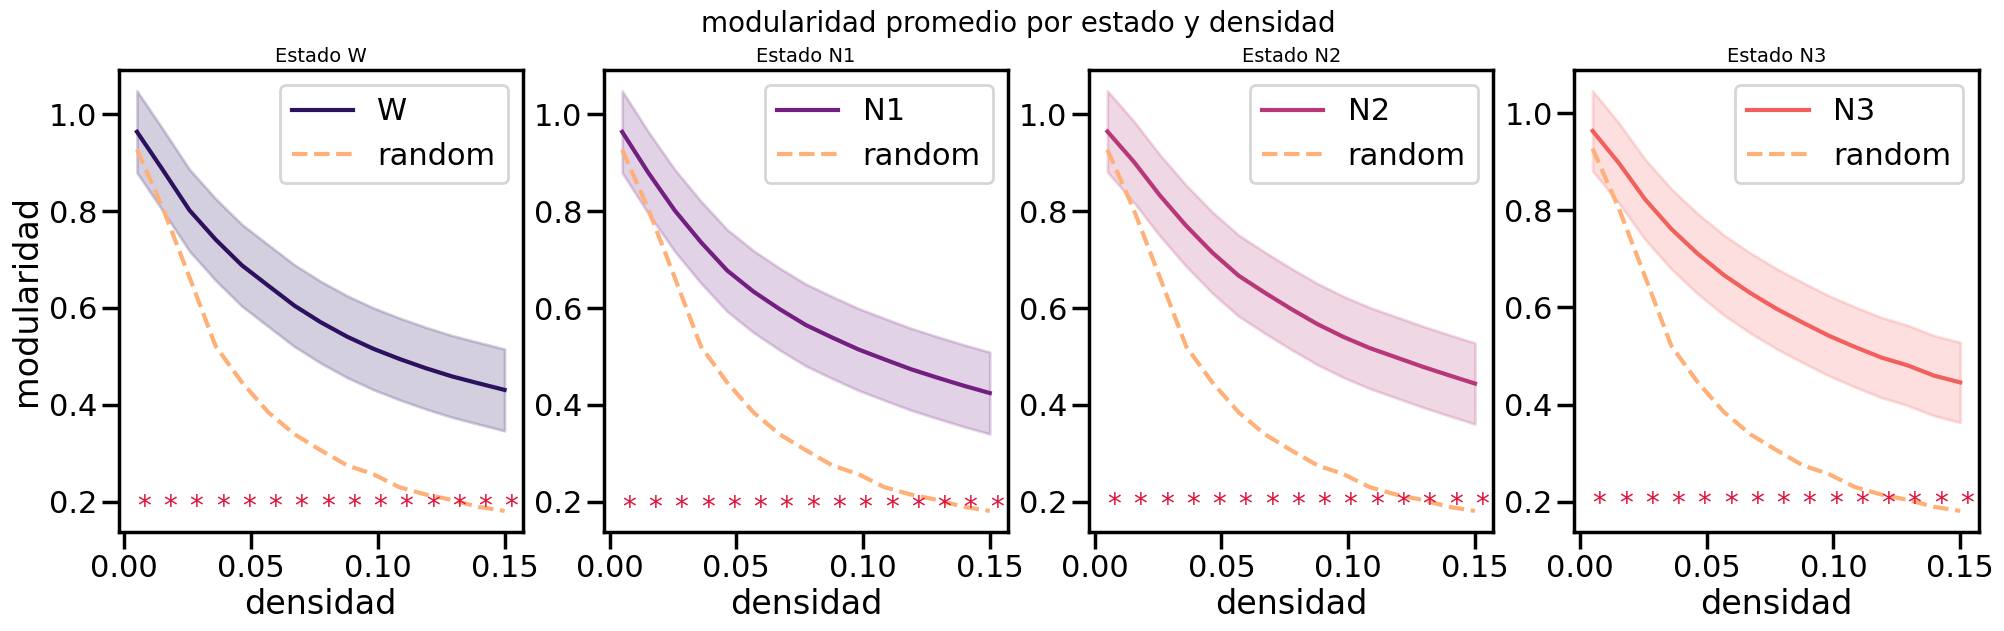

In [ ]:
estado_vs_random('modularidad') #con test de wilcoxon

<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-26-f758b13d6133>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)


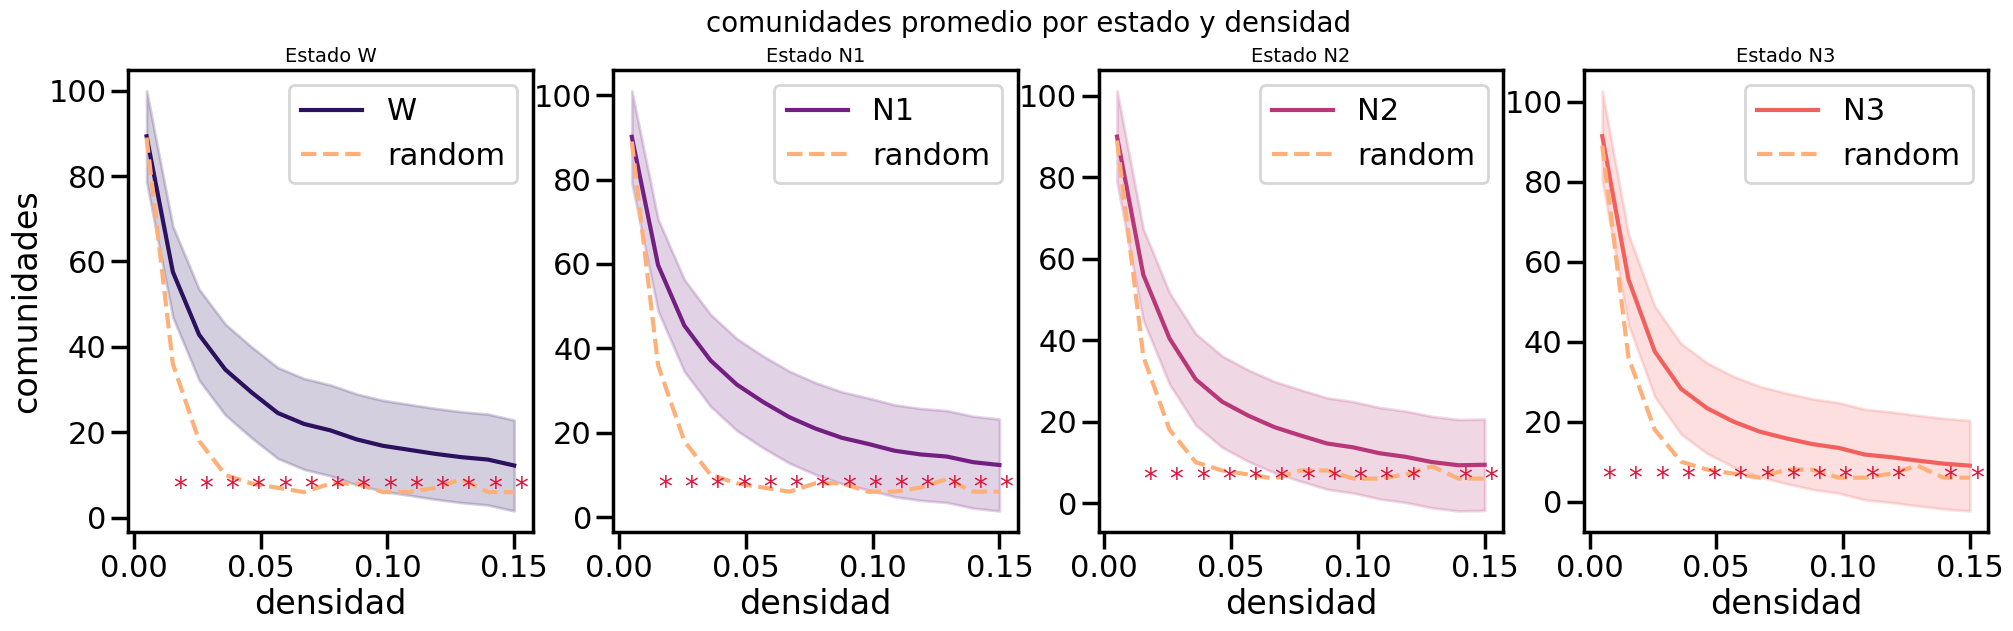

In [ ]:
estado_vs_random('comunidades') #con test de wilcoxon

In [ ]:
# no se por qué pero los promedio me vienen dando todos muy parecidos
pd.concat((curvas.loc['W'].groupby('densidad').mean() ['modularidad'],
           curvas.loc['N1'].groupby('densidad').mean()['modularidad'],
           curvas.loc['N2'].groupby('densidad').mean()['modularidad'],
           curvas.loc['N3'].groupby('densidad').mean()['modularidad']),axis=1)

modularidad  modularidad  modularidad  modularidad
densidad                                                    
0.005000     0.963474     0.964070     0.964953     0.963640
0.015357     0.883421     0.879295     0.902848     0.897529
0.025714     0.801542     0.801843     0.832741     0.822711
0.036071     0.740839     0.736083     0.770125     0.761586
0.046429     0.687704     0.677523     0.714467     0.710767
0.056786     0.645897     0.634042     0.666872     0.666743
0.067143     0.604476     0.597701     0.631569     0.629992
0.077500     0.570312     0.564824     0.598121     0.597459
0.087857     0.540652     0.539045     0.566835     0.568961
0.098214     0.515626     0.514485     0.540117     0.541683
0.108571     0.494513     0.493750     0.517186     0.518385
0.118929     0.475471     0.473606     0.498105     0.496805
0.129286     0.458502     0.456218     0.478915     0.480645
0.139643     0.444377     0.439664     0.461274     0.459586
0.150000     0.430640     0.424371     0.444025     0.445576

In [ ]:
stats.ttest_ind(curvas.loc['W'].groupby('densidad').mean()['modularidad' ].astype(float),
          curvas.loc['N1'].groupby('densidad').mean()['modularidad'].astype(float))

TtestResult(statistic=0.06662366417261957, pvalue=0.9473547577797921, df=28.0)

In [ ]:
# no se por qué pero los promedio me vienen dando todos muy parecidos
pd.concat((curvas.loc['W'].groupby('densidad').mean() ['comunidades'],
           curvas.loc['N1'].groupby('densidad').mean()['comunidades'],
           curvas.loc['N2'].groupby('densidad').mean()['comunidades'],
           curvas.loc['N3'].groupby('densidad').mean()['comunidades']),axis=1)

comunidades  comunidades  comunidades  comunidades
densidad                                                    
0.005000    89.277778    90.111111    89.944444    91.388889
0.015357    57.555556    59.722222    56.055556    55.555556
0.025714    42.833333    45.388889    40.388889    37.555556
0.036071    34.666667    37.111111    30.333333    28.222222
0.046429    29.333333    31.388889    24.888889    23.333333
0.056786    24.500000    27.277778    21.444444    20.000000
0.067143    21.944444    23.666667    18.611111    17.500000
0.077500    20.444444    20.944444    16.555556    15.833333
0.087857    18.333333    18.777778    14.611111    14.388889
0.098214    16.833333    17.333333    13.666667    13.444444
0.108571    15.888889    15.722222    12.222222    11.777778
0.118929    14.944444    14.833333    11.333333    11.111111
0.129286    14.166667    14.333333    10.055556    10.277778
0.139643    13.611111    13.000000     9.277778     9.500000
0.150000    12.222222    12.333333     9.388889     9.000000

In [ ]:
# iterar combinaciones posibles de estado
from itertools import combinations
for n, comb in enumerate(combinations(estados,2)):
    print(comb)
    if n>1:
        break


('W', 'N1')
('W', 'N2')
('W', 'N3')


Repito pero utilizando test de Wilcoxon para que sea consistente con el apartado anterior

In [ ]:
def estado_vs_estado(metrica):
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    plt.suptitle(f'{metrica} promedio por estado y densidad', size=20)

    for n, comb in enumerate(combinations(estados, 2)):
        if n > 2:
            break

        mean_values_0 = curvas.loc[comb[0]].groupby('densidad').mean()[metrica]
        mean_values_1 = curvas.loc[comb[1]].groupby('densidad').mean()[metrica]

        # Calculate standard errors of the mean
        sem_0 = curvas.loc[comb[0]].groupby('densidad').sem()[metrica]
        sem_1 = curvas.loc[comb[1]].groupby('densidad').sem()[metrica]

        # Plot curves
        ax[n].plot(mean_values_0.index, mean_values_0, label=comb[0], color='darkmagenta')
        ax[n].plot(mean_values_1.index, mean_values_1, label=comb[1], color='darksalmon')

        # Plot confidence intervals as shaded areas around the curve
        ax[n].fill_between(mean_values_0.index, mean_values_0 - 1.96 * sem_0, mean_values_0 + 1.96 * sem_0, color='darkmagenta', alpha=0.2)
        ax[n].fill_between(mean_values_1.index, mean_values_1 - 1.96 * sem_1, mean_values_1 + 1.96 * sem_1, color='darksalmon', alpha=0.2)

        # Perform Ranksum test
        p_values = pd.Series(index=densidades)
        for densidad in densidades:
            _, p_value = ranksums(curvas.loc[comb[0]].groupby('densidad').mean()[metrica].astype(float),
                                  curvas.loc[comb[1]].groupby('densidad').mean()[metrica].astype(float))
            p_values[densidad] = p_value

        # Plot significance markers
        for densidad, p_value in p_values.items():
            metrica_min = min(mean_values_0.min(), mean_values_1.min())
            if p_value < 0.05:
                ax[n].annotate('*', xy=(densidad, metrica_min), fontsize=20, color='green', ha='center')
            elif p_value < 0.1:
                ax[n].annotate('o', xy=(densidad, metrica_min), fontsize=20, color='orange', ha='center')
            else:
                ax[n].annotate(' ', xy=(densidad, metrica_min), fontsize=20, color='crimson', ha='center')

        ax[n].legend()
        ax[n].set_title(f"{comb[0]} vs {comb[1]}", fontsize=14)
        ax[n].set_xlabel('densidad')

        if n == 0:
            ax[n].set_ylabel(metrica)

    plt.savefig(f'{metrica}_comparacion_estados.png', bbox_inches = 'tight')
    plt.show()


<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)


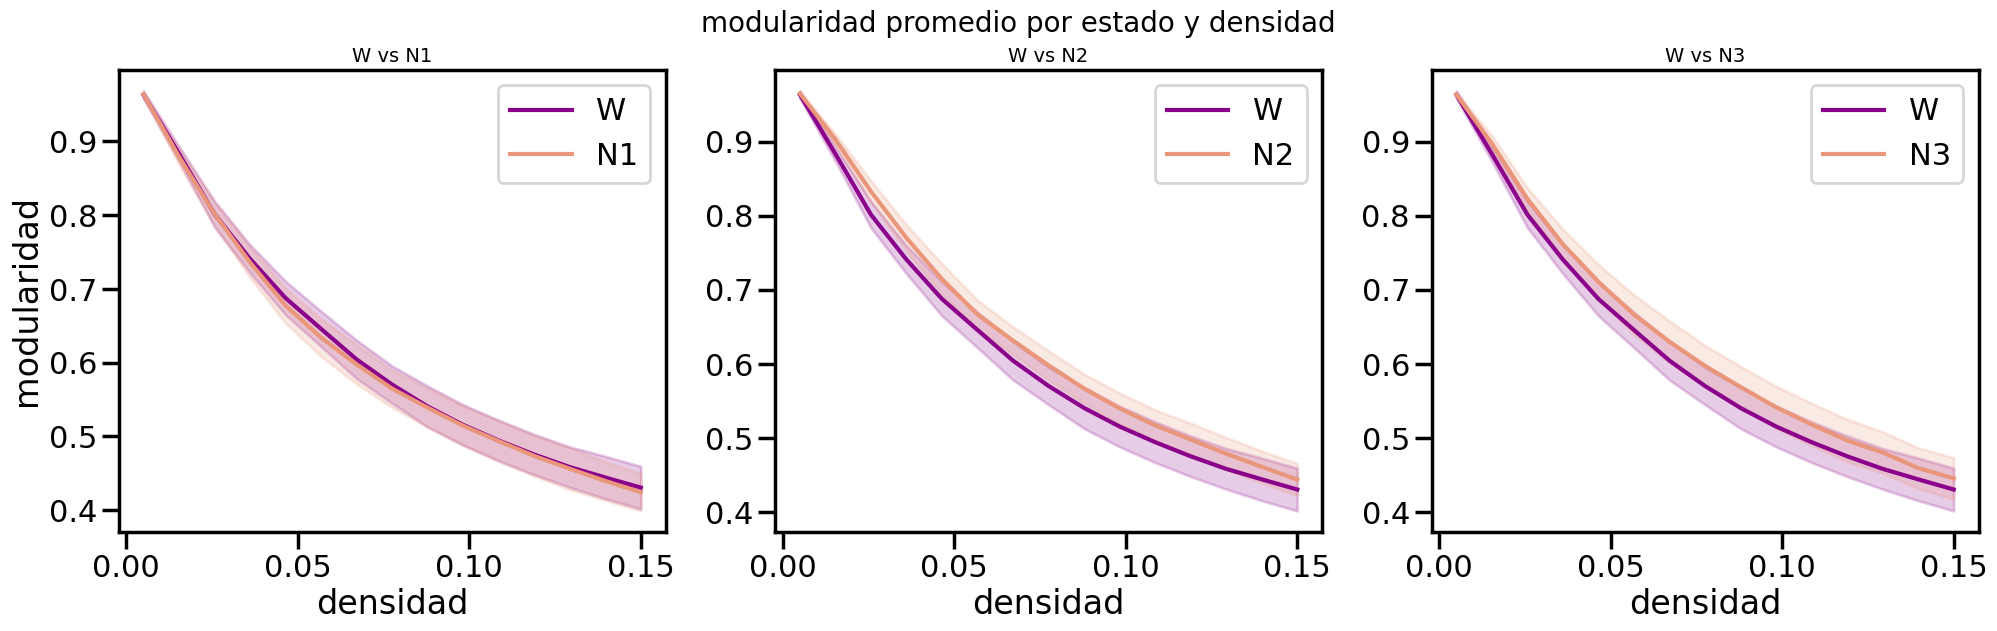

In [ ]:
estado_vs_estado('modularidad')

<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-33-15e5612c897f>:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)


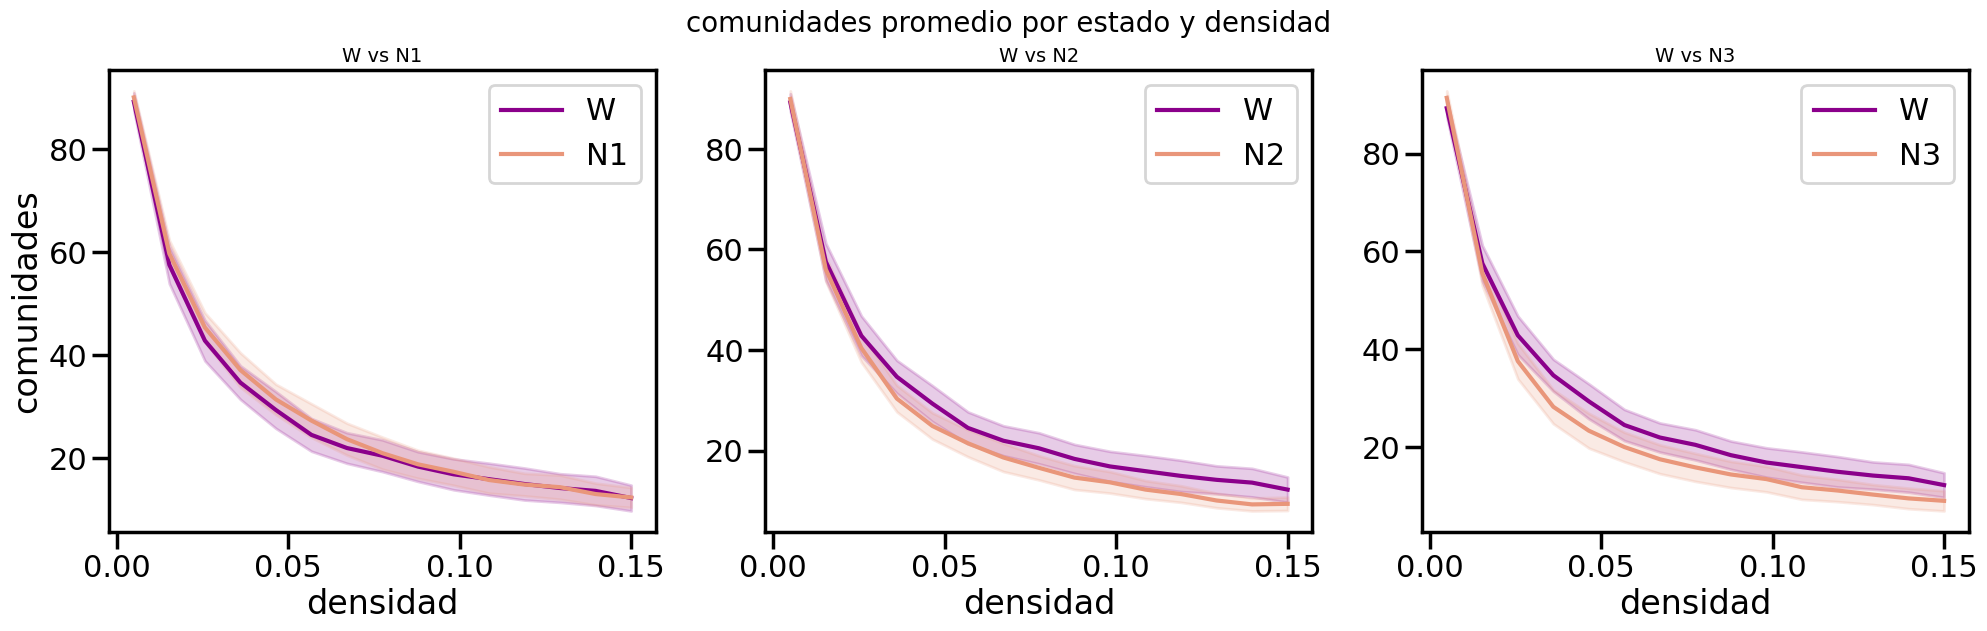

In [ ]:
estado_vs_estado('comunidades')

##Grafos de comunidades

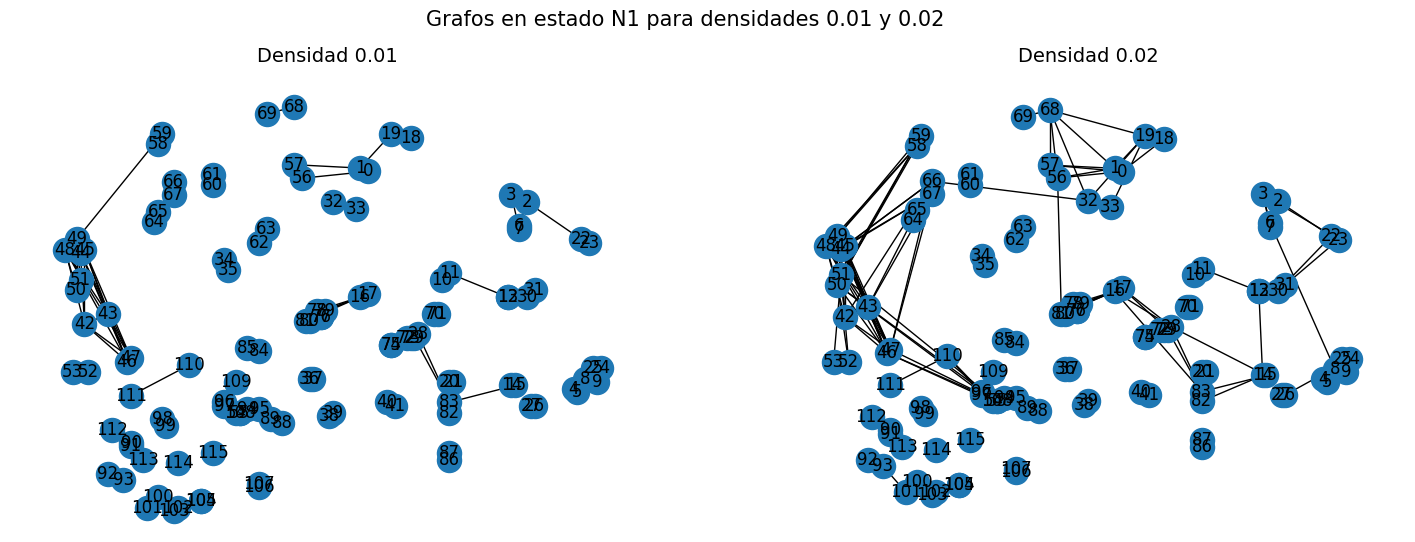

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

plt.suptitle('Grafos en estado N1 para densidades 0.01 y 0.02',size=15)
for n,densidad in enumerate([0.01,0.02]):
  G = grafo_densidad(matriz_promedio('N1'),densidad)
  nx.draw(G,layout, with_labels=True, linewidths =1,ax=ax[n])
  ax[n].set_title(f'Densidad {densidad}', fontsize=14)

<ipython-input-37-a3316bb4bb18>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)


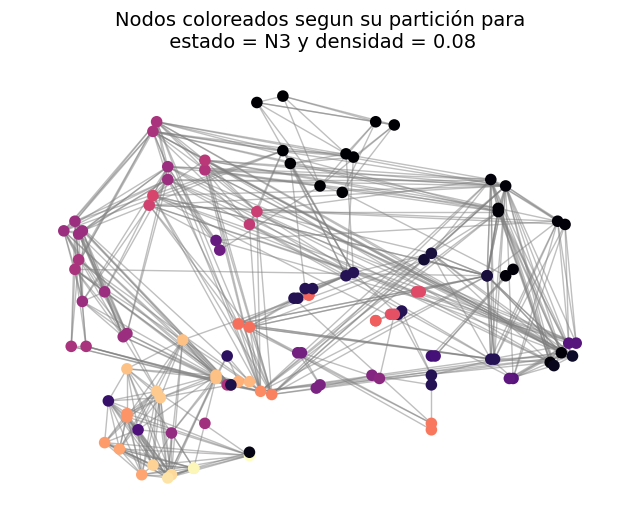

In [ ]:
layout = dict(zip(range(116),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

#Parametros, habia dicho que un valor de densidad era aquel valor para aquel en el que las curvas de modularidad se separaban mas
estado = 'N3'
densidad = 0.08

modulos = cl.best_partition(G, random_state = 42)

G = grafo_densidad(matriz_promedio('N3'), 0.08)

cmap = cm.get_cmap('magma', max(modulos.values()) + 1)

nx.draw_networkx_nodes(G, layout, modulos.keys(), node_size=40, cmap=cmap, node_color=list(modulos.values()))

nx.draw_networkx_edges(G, layout, alpha=0.5, edge_color= 'gray')

plt.axis('off')


plt.title(f'Nodos coloreados segun su partición para\n estado = {estado} y densidad = {densidad}', fontsize=14)
plt.show()

<ipython-input-38-bf00ebd06490>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)


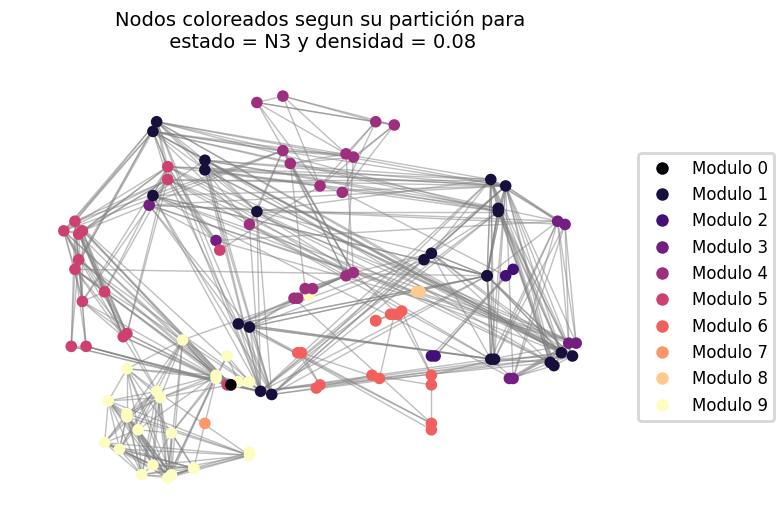

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm

layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

# Parametros, había dicho que un valor de densidad era aquel valor para aquel en el que las curvas de modularidad se separaban más
estado = 'N3'
densidad = 0.08

modulos = cl.best_partition(G, random_state=42)

G = grafo_densidad(matriz_promedio('N3'), 0.08)

cmap = cm.get_cmap('magma', max(modulos.values()) + 1)

node_colors = list(modulos.values())

# Create a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=f'Modulo {i}') for i in range(max(modulos.values()) + 1)]

# Draw nodes
nx.draw_networkx_nodes(G, layout, node_size=40, cmap=cmap, node_color=node_colors)

# Draw edges
nx.draw_networkx_edges(G, layout, alpha=0.5, edge_color='gray')

# Draw custom legend with adjusted position
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12) #aca se puede sacar la layenda si queda feo, la deje porque no contaba bien cuantos  hay


plt.axis('off')

plt.title(f'Nodos coloreados segun su partición para\n estado = {estado} y densidad = {densidad}', fontsize=14)
plt.show()


<ipython-input-39-bafa6c940c97>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-39-bafa6c940c97>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-39-bafa6c940c97>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-39-bafa6c940c97>:11: MatplotlibDeprecationWarning: The 

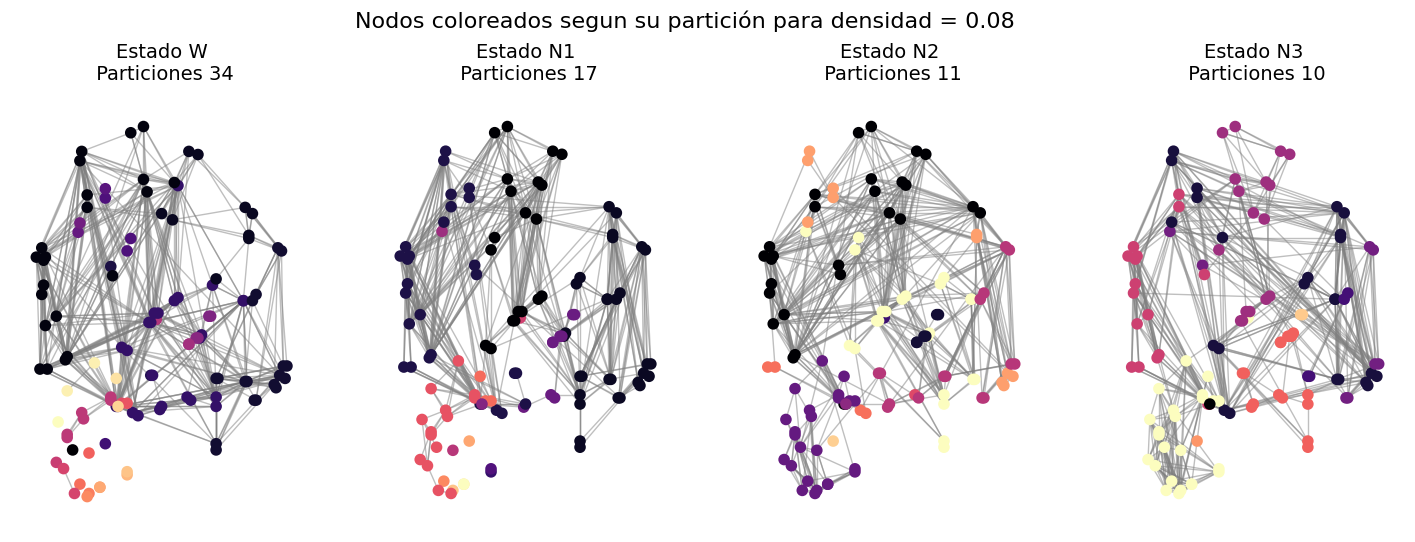

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.85})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

for n, estado in enumerate(estados):
  G = grafo_densidad(matriz_promedio(estado), 0.08)

  modulos = cl.best_partition(G, random_state=42)

  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)

  node_colors = list(modulos.values())

  # Create a custom legend
  legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=f'Modulo {i}') for i in range(max(modulos.values()) + 1)]

  # Draw nodes
  nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, cmap=cmap, node_color=node_colors)

  # Draw edges
  nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='gray')

# Draw custom legend with adjusted position
  #ax[n].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12) #aca se puede sacar la layenda si queda feo, la deje porque no contaba bien cuantos  hay


  ax[n].set_title(f'Estado {estado}\n Particiones {max(modulos.values())+1}', fontsize=14)

  ax[n].axis('off')
#plt.show()
plt.suptitle(f'Nodos coloreados segun su partición para densidad = {densidad}', size = 16);

#f'Nodos coloreados segun su partición (son {max(modulos.values())+1}) para\n estado = {estado} y densidad = {densidad}', fontsize=14

<ipython-input-40-4ec201bd0f63>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-40-4ec201bd0f63>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-40-4ec201bd0f63>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-40-4ec201bd0f63>:12: MatplotlibDeprecationWarning: The 

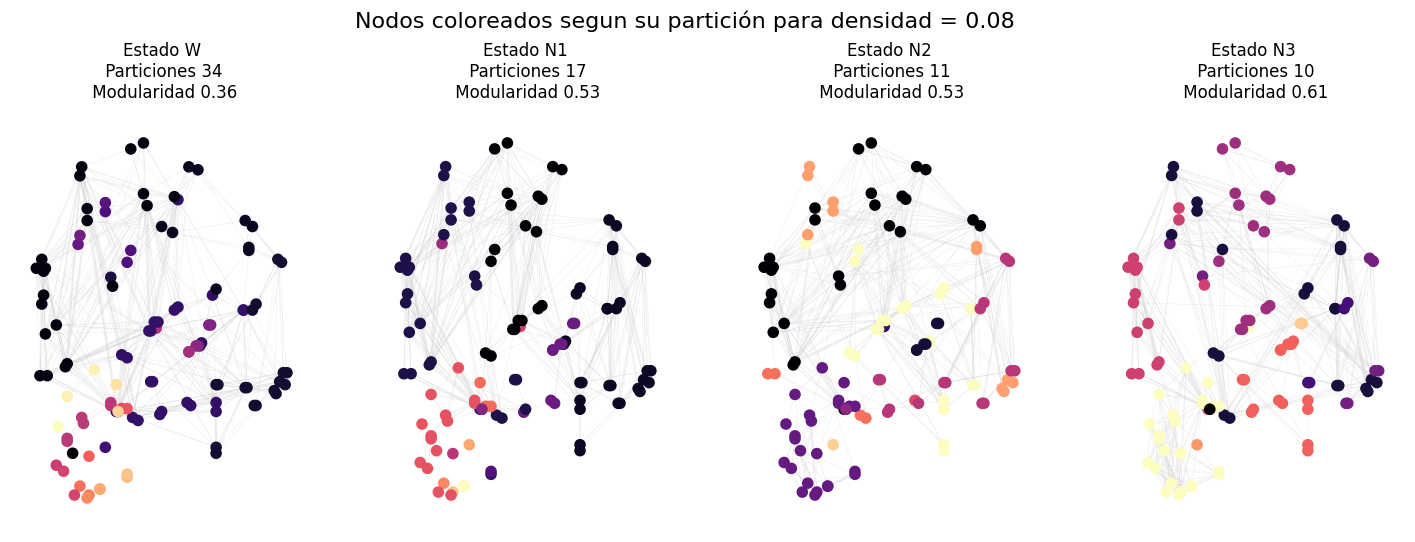

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.82})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

for n, estado in enumerate(estados):
  G = grafo_densidad(matriz_promedio(estado), 0.08)

  modulos = cl.best_partition(G, random_state=42)

  modularidad = cl.modularity(modulos, G)
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)

  node_colors = list(modulos.values())

  # Create a custom legend
  legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=f'Modulo {i}') for i in range(max(modulos.values()) + 1)]

  # Draw nodes
  nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, cmap=cmap, node_color=node_colors)

  # Draw edges
  nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='lightgray', width = 0.3)

# Draw custom legend with adjusted position
  #ax[n].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12) #aca se puede sacar la layenda si queda feo, la deje porque no contaba bien cuantos  hay


  ax[n].set_title(f'Estado {estado}\n Particiones {max(modulos.values())+1}\n Modularidad {round(modularidad,2)}', fontsize=12)

  ax[n].axis('off')
#plt.show()
plt.suptitle(f'Nodos coloreados segun su partición para densidad = {densidad}', size = 16);

plt.savefig('mapa_cerebro_comunidades.png', bbox_inches = 'tight')

#f'Nodos coloreados segun su partición (son {max(modulos.values())+1}) para\n estado = {estado} y densidad = {densidad}', fontsize=14

# Opcional 1 - tarea 2 Girvan - Newman

In [ ]:
def best_partition_girwan(G):
    modulos = nx.community.girvan_newman(G) # DEVUELVE UN ITERADOR modulos QUE ME DA LA COMUNIDADES QUE SURGEN AL IR ELIMINANDO ENLACES
    modularidad=[] # ESTE EL EL INDICE DE MODULARIDAD (Q) QUE QUEREMOS OPTIMIZAR
    mod_max = -999
    for communities in modulos:
        n_modularidad = nx.community.modularity(G,tuple(sorted(c) for c in communities)) # CALCULAMOS Q PARA CADA ITERACION
        modularidad.append(n_modularidad)
        if n_modularidad>mod_max: # ME GUARDO LA MAXIMA MODULARIDAD ENCONTRADA, Y LA PARTICIÓN DE COMUNIDADES CORRESPONDIENTE
            mod_max=n_modularidad
            modulos = tuple(sorted(c) for c in communities)
    return mod_max, modulos

In [ ]:
def refactor_nodos(modulos_girwan):
    diccionario = {}
    for nodo in range(0,117):
        for n,elemento in enumerate(modulos_girwan):
            if nodo in elemento:
                diccionario[nodo] = n
    return diccionario

<ipython-input-43-e42609796b52>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-43-e42609796b52>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-43-e42609796b52>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
<ipython-input-43-e42609796b52>:12: MatplotlibDeprecationWarning: The 

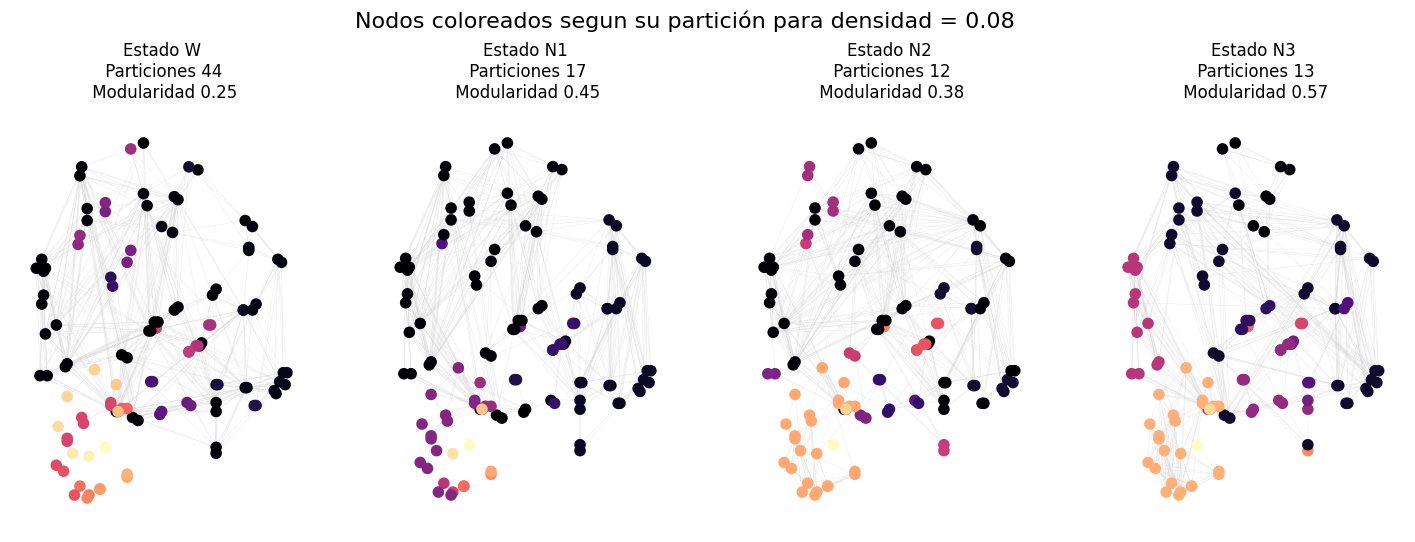

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.82})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), 0.08)

    modularidad, modulos = best_partition_girwan(G)
    modulos = refactor_nodos(modulos)

    cmap = cm.get_cmap('magma', max(modulos.values()) + 1)
    node_colors = list(modulos.values())

    # Create a custom legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=f'Modulo {i}') for i in range(max(modulos.values()) + 1)]

    # Draw nodes
    nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, cmap=cmap, node_color=node_colors)

    # Draw edges
    nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='lightgray', width = 0.3)

    # Draw custom legend with adjusted position
    #ax[n].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12) #aca se puede sacar la layenda si queda feo, la deje porque no contaba bien cuantos  hay


    ax[n].set_title(f'Estado {estado}\n Particiones {max(modulos.values())+1}\n Modularidad {round(modularidad,2)}', fontsize=12)

    ax[n].axis('off')
    #plt.show()
    plt.suptitle(f'Nodos coloreados segun su partición para densidad = {densidad}', size = 16);

    plt.savefig('mapa_cerebro_comunidades_gn.png', bbox_inches = 'tight')

    #f'Nodos coloreados segun su partición (son {max(modulos.values())+1}) para\n estado = {estado} y densidad = {densidad}', fontsize=14

#Opcional 2 - Tarea 2

In [ ]:
def estado_vs_random_bonferroni(metrica, alpha=0.05):
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    plt.suptitle(f'{metrica} promedio por estado y densidad (corrección de Bonferroni)', size=20)
    palette = sns.color_palette('magma', n_colors=len(estados) + 1)

    for n, estado in enumerate(estados):
        test = curvas.loc[estado].groupby('densidad').mean()

        # Perform rank-sum test
        p_values = pd.Series(index=densidades)
        for densidad in densidades:
            _, p_value = ranksums(curvas.loc[(estado, densidad), metrica],
                                  curvas.loc[(estado, densidad), f'{metrica}_random'])
            p_values[densidad] = p_value

        # Apply Bonferroni correction
        adjusted_alpha = alpha / len(densidades)
        print(adjusted_alpha)

        # Plot significance markers
        for densidad, p_value in p_values.items():
            if p_value < adjusted_alpha:
                ax[n].text(densidad, test[metrica].min() * 0.4, '*', fontsize=20, color='crimson')

        # Plot the line
        ax[n].plot(test.index, test[metrica], label=estado, color=palette[n])

        # Calculate and plot the confidence interval around metrica
        sem_metrica = test[metrica].sem()
        confidence_interval = 1.96 * sem_metrica
        ax[n].fill_between(test.index, test[metrica] - confidence_interval, test[metrica] + confidence_interval,
                           color=palette[n], alpha=0.2)

        ax[n].plot(test[f'{metrica}_random'], linestyle='dashed', label='random', color=palette[-1])
        ax[n].legend()
        ax[n].set_title(f'Estado {estado}', fontsize=14)
        ax[n].set_xlabel('densidad')

        if n == 0:
            ax[n].set_ylabel(metrica)

    plt.savefig(f'{metrica}_vs_densidad_bonferroni.png', bbox_inches='tight')
    plt.show()

<ipython-input-44-c6495e5d4d58>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-44-c6495e5d4d58>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-44-c6495e5d4d58>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)
<ipython-input-44-c6495e5d4d58>:10: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  p_values = pd.Series(index=densidades)


0.0033333333333333335
0.0033333333333333335
0.0033333333333333335
0.0033333333333333335


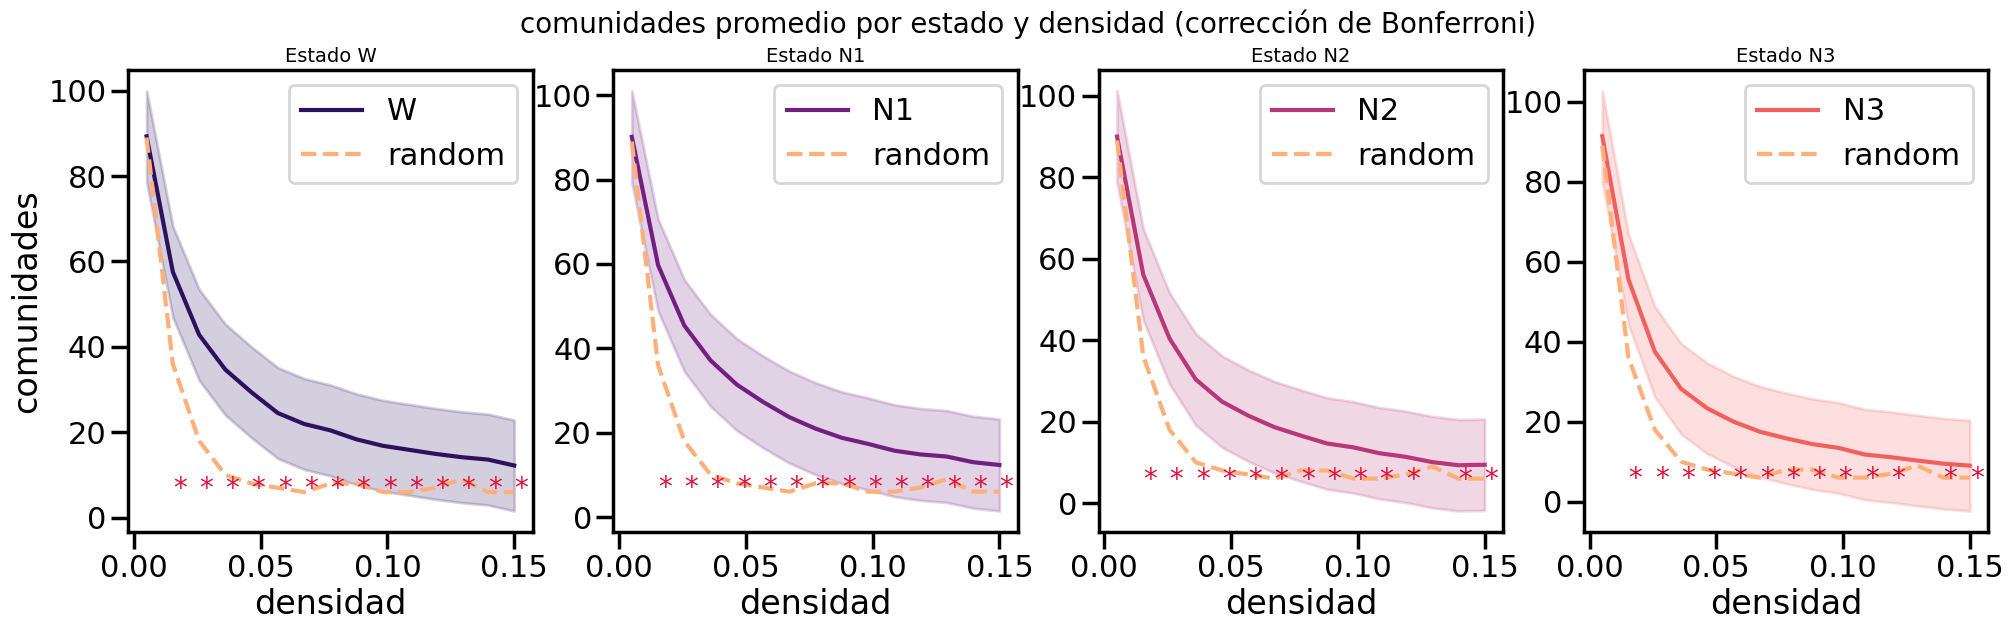

In [ ]:
estado_vs_random_bonferroni('comunidades')

#Tarea 3

In [ ]:
sujetos_list = sujetos.index[sujetos.index.str.contains(estado)]
permutaciones = pd.DataFrame(index=['sujeto','estado','densidad', 'modulos_louvain'])
#densidades = np.arange(0.01,0.16,0.01)
densidades = np.linspace(0.005,0.15,num=15)
for estado in estados:
    for densidad in densidades:
        for sujeto in sujetos.loc[sujetos['estado']==estado].index:
            # print(sujeto)
            G = grafo_densidad(pd.read_csv('DataSujetos/'+sujeto,header=None).values, densidad)
            # print(G.number_of_nodes())
            # print(G.number_of_edges())
            modulos_louvain = cl.best_partition(G, random_state = 42) #agrego random_state para fijar
            aux = pd.Series(dtype = 'float64')
            aux['estado'] = estado
            aux['sujeto'] = sujeto
            aux['densidad'] = densidad
            aux['modulos_louvain']= modulos_louvain
            permutaciones = pd.concat((permutaciones,aux.T),axis=1)
permutaciones = permutaciones.T.set_index(['estado','densidad','sujeto'])

In [ ]:
permutaciones

modulos_louvain
estado densidad sujeto                                                         
W      0.005    W_suj14.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 2, 7: ...
                W_suj18.csv   {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: ...
                W_suj15.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...
                W_suj17.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...
                W_suj2.csv    {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 1, 6: 5, 7: ...
...                                                                         ...
N3     0.150    N3_suj7.csv   {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...
                N3_suj18.csv  {0: 0, 1: 1, 2: 2, 3: 3, 4: 2, 5: 2, 6: 2, 7: ...
                N3_suj1.csv   {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...
                N3_suj15.csv  {0: 5, 1: 1, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: ...
                N3_suj16.csv  {0: 4, 1: 4, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...

[1080 rows x 1 columns]

In [ ]:
# Create an empty DataFrame with the columns you need
columns = ['estado', 'densidad', 'sujeto_1', 'sujeto_2', 'ari']
ari_data = pd.DataFrame(columns=columns)

# Iterate over unique (estado, densidad) pairs
for (estado, densidad), group in permutaciones.groupby(['estado', 'densidad']):
    # Get the list of sujetos in the current group
    sujetos_list = group.index.get_level_values('sujeto').tolist()

    # Iterate over pairs of sujetos
    for i in range(len(sujetos_list)):
        for j in range(i + 1, len(sujetos_list)):
            sujeto_1 = sujetos_list[i]
            sujeto_2 = sujetos_list[j]

            # Extract modulos_louvain for each sujeto as dictionaries
            modulos_louvain_1 = group.loc[(estado, densidad, sujeto_1), 'modulos_louvain']
            modulos_louvain_2 = group.loc[(estado, densidad, sujeto_2), 'modulos_louvain']

            # Convert modulos_louvain from dictionary to a 1D array
            labels_1 = np.array(list(modulos_louvain_1.values()))
            labels_2 = np.array(list(modulos_louvain_2.values()))

            # Calculate ARI for the pair of sujetos
            ari_value = adjusted_rand_score(labels_1, labels_2)

            # Create a temporary DataFrame for the current pair
            temp_df = pd.DataFrame({
                'estado': estado,
                'densidad': densidad,
                'sujeto_1': sujeto_1,
                'sujeto_2': sujeto_2,
                'ari': ari_value
            }, index=[0])

            # Concatenate the temporary DataFrame to the main DataFrame
            ari_data = pd.concat([ari_data, temp_df], ignore_index=True)

# Print the resulting DataFrame with ARI values for each pair of sujetos
print(ari_data)


     estado  densidad     sujeto_1      sujeto_2       ari
0        N1     0.005  N1_suj2.csv  N1_suj13.csv  0.144352
1        N1     0.005  N1_suj2.csv   N1_suj1.csv  0.112281
2        N1     0.005  N1_suj2.csv   N1_suj7.csv  0.221425
3        N1     0.005  N1_suj2.csv   N1_suj9.csv  0.166735
4        N1     0.005  N1_suj2.csv  N1_suj10.csv  0.155160
...     ...       ...          ...           ...       ...
9175      W     0.150   W_suj4.csv   W_suj16.csv  0.326215
9176      W     0.150   W_suj4.csv    W_suj8.csv  0.204352
9177      W     0.150   W_suj7.csv   W_suj16.csv  0.250832
9178      W     0.150   W_suj7.csv    W_suj8.csv  0.156493
9179      W     0.150  W_suj16.csv    W_suj8.csv  0.277168

[9180 rows x 5 columns]


In [ ]:
ari_data[ari_data['sujeto_1'].str.contains('W')].pivot_table(index='sujeto_1',columns='sujeto_2',values='ari')

sujeto_2     W_suj1.csv  W_suj10.csv  W_suj11.csv  W_suj12.csv  W_suj13.csv  \
sujeto_1                                                                      
W_suj1.csv          NaN          NaN          NaN     0.256479     0.282402   
W_suj10.csv    0.223264          NaN          NaN     0.239077     0.375881   
W_suj11.csv    0.212634     0.246424          NaN     0.347254     0.338088   
W_suj12.csv         NaN          NaN          NaN          NaN          NaN   
W_suj13.csv         NaN          NaN          NaN     0.326792          NaN   
W_suj14.csv    0.244010     0.303283     0.449045     0.377848     0.473999   
W_suj15.csv    0.123046     0.157579     0.227447     0.150291     0.175908   
W_suj16.csv         NaN          NaN          NaN          NaN          NaN   
W_suj17.csv    0.199697     0.193888     0.429538     0.320990     0.310381   
W_suj18.csv    0.247780     0.215151     0.386157     0.305193     0.331301   
W_suj2.csv     0.104933     0.148036     0.202825     0.169463     0.169702   
W_suj3.csv          NaN          NaN          NaN     0.303567     0.402268   
W_suj4.csv          NaN          NaN          NaN          NaN          NaN   
W_suj5.csv     0.228318     0.277469     0.359750     0.329774     0.332846   
W_suj6.csv     0.172005     0.219662          NaN     0.319399     0.305082   
W_suj7.csv          NaN          NaN          NaN          NaN          NaN   
W_suj9.csv     0.211688          NaN          NaN     0.314079     0.356532   

sujeto_2     W_suj15.csv  W_suj16.csv  W_suj17.csv  W_suj18.csv  W_suj2.csv  \
sujeto_1                                                                      
W_suj1.csv           NaN     0.245348          NaN          NaN         NaN   
W_suj10.csv          NaN     0.318742          NaN          NaN         NaN   
W_suj11.csv          NaN     0.423905          NaN          NaN         NaN   
W_suj12.csv          NaN     0.292274          NaN          NaN         NaN   
W_suj13.csv          NaN     0.475815          NaN          NaN         NaN   
W_suj14.csv     0.170991     0.458374     0.371340     0.404662    0.187057   
W_suj15.csv          NaN     0.195673     0.219285          NaN    0.099263   
W_suj16.csv          NaN          NaN          NaN          NaN         NaN   
W_suj17.csv          NaN     0.388147          NaN          NaN    0.164492   
W_suj18.csv     0.172244     0.437177     0.364424          NaN    0.217091   
W_suj2.csv           NaN     0.185513          NaN          NaN         NaN   
W_suj3.csv           NaN     0.498127          NaN          NaN         NaN   
W_suj4.csv           NaN     0.356855          NaN          NaN         NaN   
W_suj5.csv           NaN     0.369559          NaN          NaN         NaN   
W_suj6.csv           NaN     0.371686          NaN          NaN         NaN   
W_suj7.csv           NaN     0.407094          NaN          NaN         NaN   
W_suj9.csv           NaN     0.346792          NaN          NaN         NaN   

sujeto_2     W_suj3.csv  W_suj4.csv  W_suj5.csv  W_suj6.csv  W_suj7.csv  \
sujeto_1                                                                  
W_suj1.csv     0.281436    0.231454         NaN         NaN    0.250317   
W_suj10.csv    0.299135    0.315822         NaN         NaN    0.282256   
W_suj11.csv    0.377878    0.324625         NaN    0.461170    0.453166   
W_suj12.csv         NaN    0.305603         NaN         NaN    0.300596   
W_suj13.csv         NaN    0.320104         NaN         NaN    0.344834   
W_suj14.csv    0.378073    0.356260    0.367533    0.373529    0.384495   
W_suj15.csv    0.197818    0.187995    0.156454    0.192684    0.192449   
W_suj16.csv         NaN         NaN         NaN         NaN         NaN   
W_suj17.csv    0.344528    0.293342    0.247068    0.368604    0.365185   
W_suj18.csv    0.426561    0.259364    0.323274    0.398621    0.345951   
W_suj2.csv     0.214048    0.146160    0.178403    0.171764    0.186198   
W_suj3.csv          N

In [ ]:
# Calculate mean ARI for each unique combination of 'estado' and 'densidad'
mean_ari_data = ari_data.groupby(['estado', 'densidad'])['ari'].agg(['mean', 'std']).reset_index()

# Print the resulting DataFrame with mean ARI values for each estado and densidad
print(mean_ari_data)


   estado  densidad      mean       std
0      N1  0.005000  0.486682  0.161728
1      N1  0.015357  0.371933  0.092043
2      N1  0.025714  0.385433  0.089893
3      N1  0.036071  0.379210  0.101453
4      N1  0.046429  0.349851  0.104450
5      N1  0.056786  0.350148  0.098837
6      N1  0.067143  0.337742  0.098945
7      N1  0.077500  0.339981  0.107760
8      N1  0.087857  0.323175  0.099047
9      N1  0.098214  0.335219  0.105100
10     N1  0.108571  0.324947  0.101896
11     N1  0.118929  0.336758  0.100472
12     N1  0.129286  0.325148  0.115410
13     N1  0.139643  0.329058  0.104316
14     N1  0.150000  0.341184  0.103464
15     N2  0.005000  0.545244  0.151991
16     N2  0.015357  0.490242  0.107531
17     N2  0.025714  0.464888  0.096962
18     N2  0.036071  0.421666  0.095166
19     N2  0.046429  0.426870  0.095167
20     N2  0.056786  0.409505  0.090374
21     N2  0.067143  0.392243  0.095720
22     N2  0.077500  0.385204  0.095657
23     N2  0.087857  0.383295  0.093104


Pedia con el error standard, ahi lo calcule

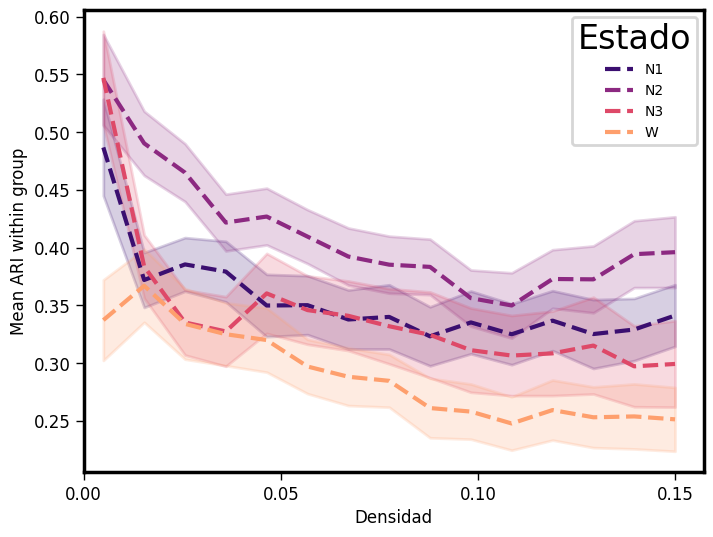

In [ ]:
# Set up the plot
plt.figure(figsize=(8, 6))

# Define a color palette (adjust as needed)
palette = sns.color_palette('magma', n_colors=len(mean_ari_data['estado'].unique()))

# Plot mean ARI versus densidad for each estado with shaded error area
for i, (estado, group) in enumerate(mean_ari_data.groupby('estado')):
    plt.plot(group['densidad'], group['mean'], label=estado, linestyle='dashed', color=palette[i])

    # Calculate standard error for the shaded error area
    std_error = group['std'] / np.sqrt(len(group))

    # Create a shaded error area
    plt.fill_between(group['densidad'], group['mean'] - std_error, group['mean'] + std_error, alpha=0.2, color=palette[i])

# Add labels and legend
plt.xlabel('Densidad', size=12)
plt.ylabel('Mean ARI within group', size=12)
#plt.title('ARI within group versus densidad para cada estado', size=14)
plt.legend(title='Estado', loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', length=6, width=1, labelsize=12)
plt.xticks(np.arange(0, 0.16, 0.05))
plt.xlim(0)

# Show the plot
plt.show()


Pedia con el error standard, ahi lo calcule

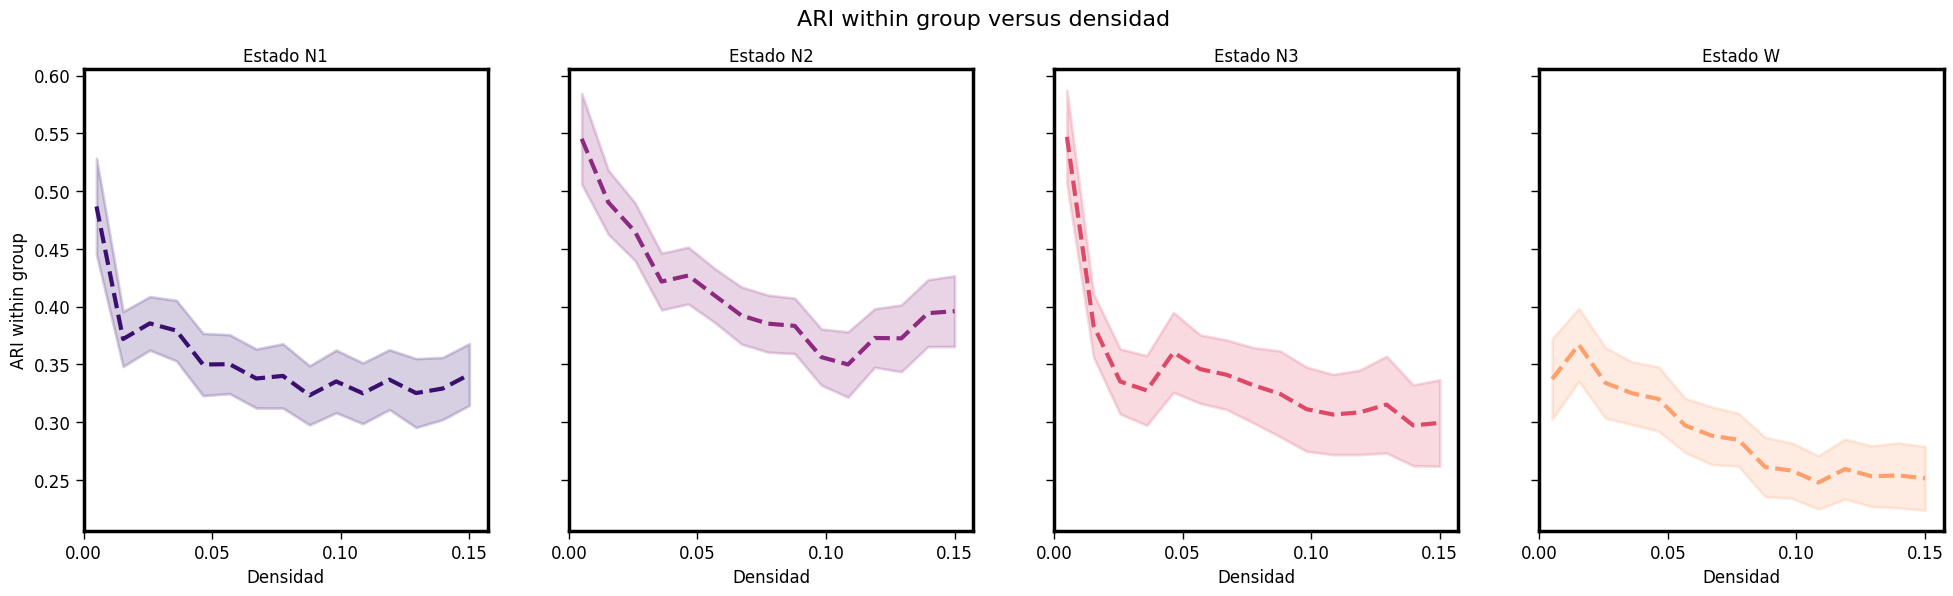

In [ ]:
# Set up subplots
fig, axes = plt.subplots(ncols=len(mean_ari_data['estado'].unique()), nrows=1, figsize=(24, 6), sharey=True)

# Define a color palette (adjust as needed)
palette = sns.color_palette('magma', n_colors=len(mean_ari_data['estado'].unique()))

# Plot mean ARI versus densidad for each estado with shaded error area
for i, (estado, group) in enumerate(mean_ari_data.groupby('estado')):
    ax = axes[i]
    ax.plot(group['densidad'], group['mean'], label=estado, linestyle='dashed', color=palette[i])

    # Calculate standard error for the shaded error area
    std_error = group['std'] / np.sqrt(len(group))

    # Create a shaded error area
    ax.fill_between(group['densidad'], group['mean'] - std_error, group['mean'] + std_error, alpha=0.2, color=palette[i])

    # Add labels and legend to the first subplot
    if i == 0:
        ax.set_ylabel('ARI within group', size=12)
        fig.suptitle('ARI within group versus densidad', size=16)

    ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=12)
    ax.set_xticks(np.arange(0, 0.16, 0.05))
    ax.set_xlim(0)

    # Add subtitle with estado
    ax.set_title(f'Estado {estado}', size=12)

    # Set x-axis label for each subplot
    ax.set_xlabel('Densidad', size=12)

# Show the plot
plt.show()


In [ ]:
permutaciones_2 = permutaciones.reset_index(level='estado')

# Now, 'estado' will be dropped from the index and become a regular column.
permutaciones_2

estado  \
densidad sujeto                
0.005    W_suj14.csv       W   
         W_suj18.csv       W   
         W_suj15.csv       W   
         W_suj17.csv       W   
         W_suj2.csv        W   
...                      ...   
0.150    N3_suj7.csv      N3   
         N3_suj18.csv     N3   
         N3_suj1.csv      N3   
         N3_suj15.csv     N3   
         N3_suj16.csv     N3   

                                                         modulos_louvain  
densidad sujeto                                                           
0.005    W_suj14.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 2, 7: ...  
         W_suj18.csv   {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: ...  
         W_suj15.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...  
         W_suj17.csv   {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: ...  
         W_suj2.csv    {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 1, 6: 5, 7: ...  
...                                                                  ...  
0.150    N3_suj7.csv   {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...  
         N3_suj18.csv  {0: 0, 1: 1, 2: 2, 3: 3, 4: 2, 5: 2, 6: 2, 7: ...  
         N3_suj1.csv   {0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...  
         N3_suj15.csv  {0: 5, 1: 1, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: ...  
         N3_suj16.csv  {0: 4, 1: 4, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: ...  

[1080 rows x 2 columns]

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Create an empty list to store DataFrames
ari_data_list = []

# Iterate over unique densidades
for densidad, group in permutaciones_2.groupby(level='densidad'):
    # Get the list of sujetos in the current group
    sujetos_list = group.index.get_level_values('sujeto').unique().tolist()

    # Iterate over pairs of sujetos
    for i, sujeto_1 in enumerate(sujetos_list):
        for sujeto_2 in sujetos_list[i + 1:]:
            try:
                # Extract modulos_louvain for each sujeto as dictionaries
                modulos_louvain_1 = permutaciones_2.loc[(densidad, sujeto_1), 'modulos_louvain']
                modulos_louvain_2 = permutaciones_2.loc[(densidad, sujeto_2), 'modulos_louvain']

                # Convert modulos_louvain from dictionary to a 1D array
                labels_1 = np.array(list(modulos_louvain_1.values()))
                labels_2 = np.array(list(modulos_louvain_2.values()))

                # Calculate ARI for the pair of sujetos
                ari_value = adjusted_rand_score(labels_1, labels_2)

                # Create a temporary DataFrame for the current pair
                temp_df = pd.DataFrame({
                    'densidad': densidad,
                    'sujeto_1': sujeto_1,
                    'sujeto_2': sujeto_2,
                    'ari': ari_value
                }, index=[0])

                # Append the temporary DataFrame to the list
                ari_data_list.append(temp_df)

            except Exception as e:
                print(f"Error processing ({densidad}, {sujeto_1}, {sujeto_2}): {e}")

# Concatenate all DataFrames in the list into the final DataFrame
ari_data_sujetos = pd.concat(ari_data_list, ignore_index=True)

# Print the resulting DataFrame with ARI values for each pair of sujetos within each densidad
print(ari_data_sujetos)


       densidad      sujeto_1      sujeto_2       ari
0         0.005   W_suj14.csv   W_suj18.csv  0.496237
1         0.005   W_suj14.csv   W_suj15.csv  0.217579
2         0.005   W_suj14.csv   W_suj17.csv  0.279145
3         0.005   W_suj14.csv    W_suj2.csv  0.136524
4         0.005   W_suj14.csv    W_suj5.csv  0.231200
...         ...           ...           ...       ...
38335     0.150  N3_suj18.csv  N3_suj15.csv  0.224103
38336     0.150  N3_suj18.csv  N3_suj16.csv  0.316842
38337     0.150   N3_suj1.csv  N3_suj15.csv  0.311009
38338     0.150   N3_suj1.csv  N3_suj16.csv  0.709381
38339     0.150  N3_suj15.csv  N3_suj16.csv  0.331151

[38340 rows x 4 columns]


Lo mismo, pero combino solo los estados N con el W

In [ ]:
ari_data_sujetos

densidad      sujeto_1      sujeto_2       ari
0         0.005   W_suj14.csv   W_suj18.csv  0.496237
1         0.005   W_suj14.csv   W_suj15.csv  0.217579
2         0.005   W_suj14.csv   W_suj17.csv  0.279145
3         0.005   W_suj14.csv    W_suj2.csv  0.136524
4         0.005   W_suj14.csv    W_suj5.csv  0.231200
...         ...           ...           ...       ...
38335     0.150  N3_suj18.csv  N3_suj15.csv  0.224103
38336     0.150  N3_suj18.csv  N3_suj16.csv  0.316842
38337     0.150   N3_suj1.csv  N3_suj15.csv  0.311009
38338     0.150   N3_suj1.csv  N3_suj16.csv  0.709381
38339     0.150  N3_suj15.csv  N3_suj16.csv  0.331151

[38340 rows x 4 columns]

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Create an empty list to store DataFrames
ari_data_list = []

# Iterate over unique densidades
for densidad, group in permutaciones_2.groupby('densidad'):
    # Get the list of unique sujetos in the current group with estado 'W'
    sujetos_w = group.loc[group['estado'] == 'W'].index.get_level_values('sujeto').unique().tolist()

    # Iterate over pairs of subjects with estado 'W' and other estados
    for sujeto_1 in sujetos_w:
        for estado_2, group_2 in group.groupby('estado'):
            if estado_2 == 'W':
                continue

            sujetos_2 = group_2.index.get_level_values('sujeto').unique().tolist()

            for sujeto_2 in sujetos_2:
                try:
                    # Extract modulos_louvain for each sujeto as dictionaries
                    modulos_louvain_1 = permutaciones_2.loc[(densidad, sujeto_1), 'modulos_louvain']
                    modulos_louvain_2 = permutaciones_2.loc[(densidad, sujeto_2), 'modulos_louvain']

                    # Convert modulos_louvain from dictionary to a 1D array
                    labels_1 = np.array(list(modulos_louvain_1.values()))
                    labels_2 = np.array(list(modulos_louvain_2.values()))

                    # Calculate ARI for the pair of subjects
                    ari_value = adjusted_rand_score(labels_1, labels_2)

                    # Create a temporary DataFrame for the current pair
                    temp_df = pd.DataFrame({
                        'densidad': densidad,
                        'estado_1': 'W',
                        'sujeto_1': sujeto_1,
                        'estado_2': estado_2,
                        'sujeto_2': sujeto_2,
                        'ari': ari_value
                    }, index=[0])

                    # Append the temporary DataFrame to the list
                    ari_data_list.append(temp_df)

                except Exception as e:
                    print(f"Error processing ({densidad}, 'W', {sujeto_1}, {estado_2}, {sujeto_2}): {e}")

# Concatenate all DataFrames in the list into the final DataFrame
ari_data_sujetos_estado_w = pd.concat(ari_data_list, ignore_index=True)

# Print the resulting DataFrame with ARI values for each pair of subjects within each density and with estado 'W'
print(ari_data_sujetos_estado_w)


       densidad estado_1     sujeto_1 estado_2      sujeto_2       ari
0         0.005        W  W_suj14.csv       N1   N1_suj2.csv  0.144231
1         0.005        W  W_suj14.csv       N1  N1_suj13.csv  0.398230
2         0.005        W  W_suj14.csv       N1   N1_suj1.csv  0.468374
3         0.005        W  W_suj14.csv       N1   N1_suj7.csv  0.367744
4         0.005        W  W_suj14.csv       N1   N1_suj9.csv  0.442329
...         ...      ...          ...      ...           ...       ...
14575     0.150        W   W_suj8.csv       N3   N3_suj7.csv  0.224114
14576     0.150        W   W_suj8.csv       N3  N3_suj18.csv  0.156270
14577     0.150        W   W_suj8.csv       N3   N3_suj1.csv  0.207295
14578     0.150        W   W_suj8.csv       N3  N3_suj15.csv  0.134977
14579     0.150        W   W_suj8.csv       N3  N3_suj16.csv  0.228293

[14580 rows x 6 columns]


In [ ]:
ari_data_sujetos_estado_w

densidad estado_1     sujeto_1 estado_2      sujeto_2       ari
0         0.005        W  W_suj14.csv       N1   N1_suj2.csv  0.144231
1         0.005        W  W_suj14.csv       N1  N1_suj13.csv  0.398230
2         0.005        W  W_suj14.csv       N1   N1_suj1.csv  0.468374
3         0.005        W  W_suj14.csv       N1   N1_suj7.csv  0.367744
4         0.005        W  W_suj14.csv       N1   N1_suj9.csv  0.442329
...         ...      ...          ...      ...           ...       ...
14575     0.150        W   W_suj8.csv       N3   N3_suj7.csv  0.224114
14576     0.150        W   W_suj8.csv       N3  N3_suj18.csv  0.156270
14577     0.150        W   W_suj8.csv       N3   N3_suj1.csv  0.207295
14578     0.150        W   W_suj8.csv       N3  N3_suj15.csv  0.134977
14579     0.150        W   W_suj8.csv       N3  N3_suj16.csv  0.228293

[14580 rows x 6 columns]

In [ ]:
# Calculate mean ARI for each unique combination of 'estado', 'densidad', and 'sujeto_1', 'sujeto_2'
mean_ari_data_perm = ari_data_sujetos_estado_w.groupby(['estado_1', 'estado_2', 'densidad'])['ari'].agg(['mean', 'std']).reset_index()

# Print the resulting DataFrame with mean ARI values for each combination
print(mean_ari_data_perm)

   estado_1 estado_2  densidad      mean       std
0         W       N1  0.005000  0.404374  0.154870
1         W       N1  0.015357  0.369000  0.113669
2         W       N1  0.025714  0.363139  0.113464
3         W       N1  0.036071  0.355254  0.106418
4         W       N1  0.046429  0.342266  0.109547
5         W       N1  0.056786  0.325402  0.095075
6         W       N1  0.067143  0.318522  0.104596
7         W       N1  0.077500  0.313982  0.101977
8         W       N1  0.087857  0.298513  0.104271
9         W       N1  0.098214  0.291189  0.101633
10        W       N1  0.108571  0.282105  0.095647
11        W       N1  0.118929  0.291509  0.098459
12        W       N1  0.129286  0.280335  0.102993
13        W       N1  0.139643  0.284208  0.106127
14        W       N1  0.150000  0.289211  0.105406
15        W       N2  0.005000  0.404475  0.139587
16        W       N2  0.015357  0.384545  0.099581
17        W       N2  0.025714  0.361053  0.097608
18        W       N2  0.036071 

In [ ]:
mean_data_ari_n1 = mean_ari_data[mean_ari_data['estado']=='N1']
mean_data_ari_n1_perm = mean_ari_data_perm[mean_ari_data_perm['estado_2']=='N1']

# Assuming df1 and df2 are your DataFrames
# Add prefixes to the columns of each DataFrame
mean_data_ari_n1_perm = mean_data_ari_n1_perm.add_prefix('perm_')

n1_comp = pd.concat([mean_data_ari_n1, mean_data_ari_n1_perm], axis = 1)

In [ ]:
n1_comp

estado  densidad      mean       std perm_estado_1 perm_estado_2  \
0      N1  0.005000  0.486682  0.161728             W            N1   
1      N1  0.015357  0.371933  0.092043             W            N1   
2      N1  0.025714  0.385433  0.089893             W            N1   
3      N1  0.036071  0.379210  0.101453             W            N1   
4      N1  0.046429  0.349851  0.104450             W            N1   
5      N1  0.056786  0.350148  0.098837             W            N1   
6      N1  0.067143  0.337742  0.098945             W            N1   
7      N1  0.077500  0.339981  0.107760             W            N1   
8      N1  0.087857  0.323175  0.099047             W            N1   
9      N1  0.098214  0.335219  0.105100             W            N1   
10     N1  0.108571  0.324947  0.101896             W            N1   
11     N1  0.118929  0.336758  0.100472             W            N1   
12     N1  0.129286  0.325148  0.115410             W            N1   
13     N1  0.139643  0.329058  0.104316             W            N1   
14     N1  0.150000  0.341184  0.103464             W            N1   

    perm_densidad  perm_mean  perm_std  
0        0.005000   0.404374  0.154870  
1        0.015357   0.369000  0.113669  
2        0.025714   0.363139  0.113464  
3        0.036071   0.355254  0.106418  
4        0.046429   0.342266  0.109547  
5        0.056786   0.325402  0.095075  
6        0.067143   0.318522  0.104596  
7        0.077500   0.313982  0.101977  
8        0.087857   0.298513  0.104271  
9        0.098214   0.291189  0.101633  
10       0.108571   0.282105  0.095647  
11       0.118929   0.291509  0.098459  
12       0.129286   0.280335  0.102993  
13       0.139643   0.284208  0.106127  
14       0.150000   0.289211  0.105406

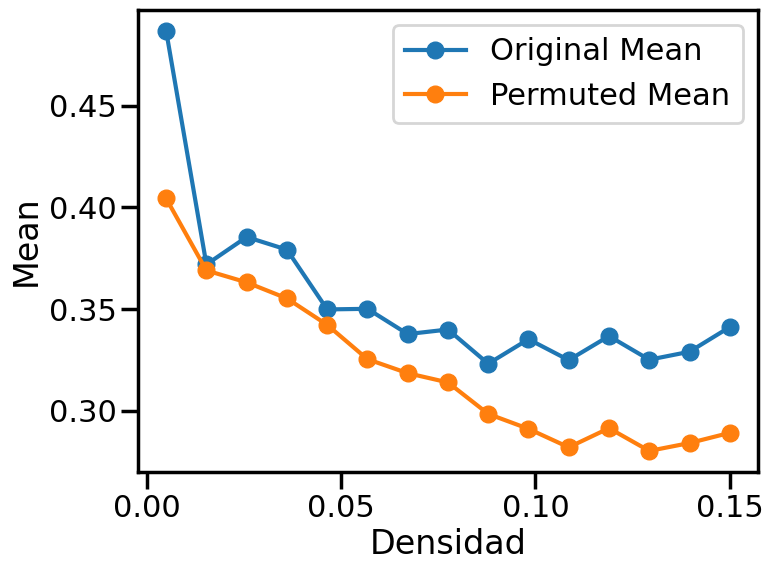

In [ ]:
# Extract relevant columns for original DataFrame
original_data = n1_comp[['densidad', 'mean']]

# Extract relevant columns for permuted DataFrame
permuted_data = n1_comp[['perm_densidad', 'perm_mean']]

# Plot mean versus densidad for both original and permuted DataFrames
plt.plot(original_data['densidad'], original_data['mean'], label='Original Mean', marker='o')
plt.plot(permuted_data['perm_densidad'], permuted_data['perm_mean'], label='Permuted Mean', marker='o')

# Add labels and legend
plt.xlabel('Densidad')
plt.ylabel('Mean')
plt.legend()

# Show the plot
plt.show()


# Tarea 3 (pepe version)

In [ ]:
# obtengo los modulos de cada sujeto en cada densidad en cada estado
modulos = pd.DataFrame()
for densidad in densidades:
    for estado in estados:
        for sujeto in sujetos.loc[sujetos['estado']==estado].index:
            aux = pd.DataFrame()
            aux.loc[sujeto,'estado'] = estado
            aux.loc[sujeto,'densidad'] = densidad
            G = grafo_densidad(pd.read_csv('DataSujetos/'+sujeto,header=None).values, densidad)
            modulos_sujeto = cl.best_partition(G, random_state = 42)
            for node in range(G.number_of_nodes()):
                aux.loc[sujeto,node] = modulos_sujeto[node]
            modulos = pd.concat((modulos,aux),axis=0)
modulos.reset_index(inplace=True)
modulos.set_index(['densidad','estado','index'],inplace=True)
modulos = modulos.applymap(int)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
<ipython-input-62-61d0a3d6cbe2>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aux.loc[sujeto,node] = modulos_sujeto[node]
<ipython-input-62-61d0a3d6cbe2>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aux.loc[sujeto,node] = modulos_sujeto[node]
<ipython-input-62-61d0a3d6cbe2>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [ ]:
from itertools import combinations
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
#armo el rand score intra estado
rands_total = pd.DataFrame()
for densidad in densidades:
    for estado in estados:
        sujetos = modulos.loc[(densidad,estado)].index
        rands = pd.DataFrame(index=sujetos,columns=sujetos.copy())
        rands.index.name = 'sujeto_1'
        rands.columns.name = 'sujeto_2'
        for combinacion in combinations(sujetos,2):
            sujeto_1 = modulos.loc[(densidad,estado,combinacion[0])]
            sujeto_2 = modulos.loc[(densidad,estado,combinacion[1])]
            #rand index
            rands.loc[combinacion[0],combinacion[1]] = adjusted_rand_score(sujeto_1,sujeto_2)
            # rands.loc[combinacion[1],combinacion[0]] = adjusted_rand_score(sujeto_1,sujeto_2)
        rands = rands.reset_index().melt(id_vars='sujeto_1').dropna()
        rands['estado'] = estado
        rands['densidad'] = densidad
        # display(rands)
        rands_total = pd.concat((rands_total,rands),axis=0,ignore_index=True)
rands_total.to_pickle('experimento.pkl')

<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  sujetos = modulos.loc[(densidad,estado)].index
<ipython-input-64-4e3337d8be4c>:5: PerformanceWarning: indexing 

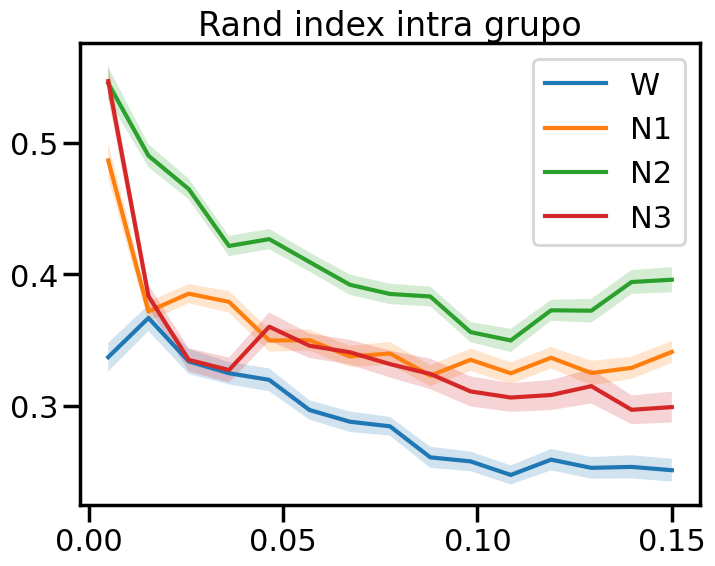

In [ ]:
for n, estado in enumerate(estados):
    test = rands_total[rands_total['densidad'] != 0].groupby(['estado', 'densidad']).agg({'value': ['mean', 'sem', lambda x: x.mean() - x.sem(), lambda x: x.mean() +x.sem()]}).loc[estado, 'value']

    plt.plot(test['mean'], label=estado)
    plt.fill_between(test.index.get_level_values('densidad'), test['<lambda_0>'], test['<lambda_1>'], alpha=0.2)
plt.title('Rand index intra grupo')
plt.legend();

In [ ]:
import random
#función para permutar sujetos
def permutacion(N='N1',prob=.5):
    #permutacion
    sujetos = os.listdir('DataSujetos/')

    sujetos_W = list(filter(lambda x: 'W' in x, sujetos))
    sujetos_N = list(filter(lambda x: N in x, sujetos))

    for n in range(19):
        if random.random()>prob:
            sujetos_W[n],sujetos_N[n] = sujetos_N[n], sujetos_W[n]

    return sujetos_W,sujetos_N

In [ ]:
random.seed(42)
rands_perm = pd.DataFrame()
for iteracion in range(100):
    print("Vuelta ",iteracion,end='\r')
    for N in ['N1','N2','N3']:
        perm = permutacion(N=N)
        for densidad in densidades:
            for n, estado in enumerate(['W',N]):
                sujetos = perm[n]
                rands = pd.DataFrame(index=sujetos,columns=sujetos.copy())
                rands.index.name = 'sujeto_1'
                rands.columns.name = 'sujeto_2'
                for e,combinacion in enumerate(combinations(sujetos,2)):
                    sujeto_1 = modulos.loc[(densidad,combinacion[0].split('_')[0],combinacion[0])]
                    sujeto_2 = modulos.loc[(densidad,combinacion[1].split('_')[0],combinacion[1])]
                    #rand index
                    rands.loc[combinacion[0],combinacion[1]] = adjusted_rand_score(sujeto_1,sujeto_2)
                    # rands.loc[combinacion[1],combinacion[0]] = adjusted_rand_score(sujeto_1,sujeto_2)
                rands = rands.reset_index().melt(id_vars='sujeto_1').dropna()
                rands['estado'] = estado
                rands['densidad'] = densidad
                rands['experimento'] = 'W_'+N
                rands['iteracion'] = iteracion
                # display(rands)
                rands_perm = pd.concat((rands_perm,rands),axis=0,ignore_index=True)
rands_perm.to_pickle('experimento_permutaciones.pkl')

IndexError: ignored

# FALTA PROMEDIAR RI ENTRE N1 y W

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

pickle_file_path = '/content/drive/MyDrive/TP 1 DMCyT 2023/TP 2/experimento_permutaciones.pkl'

with open(pickle_file_path, 'rb') as file:
    rands_perm = pickle.load(file)

In [ ]:
pickle_file_path_2 = '/content/drive/MyDrive/TP 1 DMCyT 2023/TP 2/experimento.pkl'

with open(pickle_file_path_2, 'rb') as file:
    rands_total = pickle.load(file)

In [ ]:
p_valores = {}

for estado in ['N1','N2','N3']:
    p_valores[estado] = pd.Series(index=densidades)
    for densidad in densidades:
        obs_W = rands_obs[(rands_obs['densidad']==densidad)&(rands_obs['estado']=='W')].reset_index(drop=True).add_suffix('_W')
        obs_N = rands_obs[(rands_obs['densidad']==densidad)&(rands_obs['estado']==estado)].reset_index(drop=True).add_suffix('_'+estado)

        obs = pd.concat((obs_W,obs_N),axis=1)
        obs['value'] = (obs['value_'+estado] + obs['value_W'])/2

        exp_cond = (rands_perm['experimento']=='W_'+estado)
        dens_cond = (rands_perm['densidad']==densidad)

        rands_perm__W_mejorado = pd.DataFrame()
        rands_perm_N_mejorado = pd.DataFrame()

        for iteracion in range(100):
            aux_W = rands_perm[dens_cond&(rands_perm['estado']=='W')    & exp_cond & (rands_perm['iteracion']==iteracion)].reset_index(drop=True)
            aux_N = rands_perm[dens_cond&(rands_perm['estado']==estado) & exp_cond & (rands_perm['iteracion']==iteracion)].reset_index(drop=True)
            print("estado: ",estado,"\tdensidad: ",densidad,"\t",iteracion,end='\r')
            rands_perm__W_mejorado = pd.concat((rands_perm__W_mejorado,aux_W),axis=1)
            rands_perm_N_mejorado = pd.concat((rands_perm_N_mejorado,aux_N),axis=1)

        perm_W = rands_perm__W_mejorado['value'].mean(axis=1)
        perm_N = rands_perm_N_mejorado['value'].mean(axis=1)

        perm = pd.concat((perm_W,perm_N),axis=1,keys=['W',estado])
        perm['value'] = (perm[estado] + perm['W'])/2

        p_valor = pd.concat((obs['value'],perm['value']),axis=1,keys=['obs','perm'])

        p_valor['comparacion'] = p_valor['obs']<p_valor['perm']

        p_valores[estado][densidad] = p_valor['comparacion'].sum()/100

In [ ]:
def plot_permutacion():
    palette = sns.color_palette("magma", n_colors=2)

    fig, ax = plt.subplots(1,3,figsize=(18,6))
    fig.suptitle('ARI within group vs densidad', size=16)

    for n, N in enumerate(['N1','N2','N3']):
        obs = rands_obs[rands_obs['densidad']!=0].groupby(['estado','densidad']).agg({'value': ['mean', lambda x: x.mean()-x.sem(),lambda x: x.mean()+x.sem()]})

        test_obs_W = obs.loc['W','value']
        test_obs_N = obs.loc[N,'value']
        test_final = ((test_obs_N+test_obs_W)/2)

        perm = rands_perm[rands_perm['densidad']!=0].groupby(['experimento','estado','densidad']).agg({'value': ['mean', lambda x: x.mean()-x.sem(),lambda x: x.mean()+x.sem()]})
        test_perm_W = perm.loc[('W_'+N,'W'),'value']
        test_perm_N = perm.loc[('W_'+N,N),'value']
        test_perm_final = ((test_perm_N+test_perm_W)/2)

        # Plot significance markers
        for densidad, p_value in p_valores[N].items():
            if p_value < 0.05:
                ax[n].text(densidad, test_perm_final['mean'].min(), '*', fontsize=20, color='crimson')

        ax[n].plot(test_final['mean'],label='observado',color=palette[0])
        ax[n].fill_between(test_final.index,test_final['<lambda_0>'],test_final['<lambda_1>'],alpha=0.2,color=palette[0])
        ax[n].plot(test_perm_final['mean'],label='permutado',color=palette[1])
        ax[n].fill_between(test_perm_final.index,test_perm_final['<lambda_0>'],test_perm_final['<lambda_1>'],alpha=0.2,color=palette[1])
        ax[n].legend()
        # Set labels and legend
        ax[n].set_ylabel('RI', size = 12)
        ax[n].set_xlabel('Densidad', size = 12)
        # Set tick font size
        ax[n].tick_params(axis='both', which='major', labelsize=10)
        ax[n].set_title(f'W-{N}',size=14)
    # Set legend font size
    for a in ax.flat:
        a.legend(fontsize=12)

In [ ]:
plot_permutacion()

# Opcional 3

In [ ]:
sujetos_list

In [ ]:
estados

['W', 'N1', 'N2', 'N3']

In [ ]:
roles_list = []

# Assuming `sujetos_list` and `estados` are defined before this code snippet

# Initialize roles DataFrame outside the loops
roles = pd.DataFrame(index=['sujeto', 'estado', 'densidad'])

#densidades = np.arange(0.01, 0.16, 0.01)
densidades = np.linspace(0.005, 0.15, num=15)

# Iterate over each state
for estado in estados:
    # Filter sujetos based on the current estado
    sujetos_estado = [sujeto for sujeto in sujetos_list if estado in sujeto]

    # Iterate over each density
    for densidad in densidades:
        # Iterate over each subject in sujetos_estado
        for sujeto in sujetos_estado:
            # Construct the graph and perform Louvain community detection
            G = grafo_densidad(pd.read_csv('DataSujetos/' + sujeto, header=None).values, densidad)
            modulos_louvain = cl.best_partition(G, random_state=42)
            grados = dict(G.degree())

            # Create a Series for the current iteration
            aux = pd.Series(dtype='float64')
            aux['estado'] = estado
            aux['sujeto'] = sujeto
            aux['densidad'] = densidad
            aux['modulos_louvain'] = modulos_louvain
            aux['grados'] = grados
            aux['estructura'] = G

            # Append the Series to the list
            roles_list.append(aux)

# Concatenate the list of DataFrames into the final roles DataFrame
roles = pd.concat(roles_list, axis=1).T.set_index(['estado', 'densidad', 'sujeto'])


In [ ]:
def calculate_community_size(row):
    communities = row['modulos_louvain']

    community_sizes = {}

    for node, community_label in communities.items():
        community_sizes[node] = sum(1 for member_label in communities.values() if member_label == community_label)

    return community_sizes

# Assuming 'roles' is your DataFrame
# Apply the function to calculate community sizes for each row
roles['community_sizes'] = roles.apply(calculate_community_size, axis=1)

In [ ]:
def calculate_intracommunity_degree(row):
    graph_structure = row['estructura']
    communities = row['modulos_louvain']

    intracommunity_degrees = {}

    for node, community_label in communities.items():
        intracommunity_degrees[node] = sum(1 for neighbor in graph_structure.neighbors(node) if communities[neighbor] == community_label and neighbor != node)

    return intracommunity_degrees

# Assuming 'roles' is your DataFrame
# Apply the function to calculate intracommunity degrees for each row
roles['intracommunity_degrees'] = roles.apply(calculate_intracommunity_degree, axis=1)


In [ ]:
from scipy.stats import zscore

def calculate_intra_community_z_scores(row):
    intra_community_degree_dict = row['intracommunity_degrees']
    community_size_dict = row['community_sizes']

    # Calculate z-scores within each community
    intra_community_z_scores = {}
    for node, community_label in intra_community_degree_dict.items():
        community_nodes = [n for n, label in intra_community_degree_dict.items() if label == community_label]
        community_degrees = [intra_community_degree_dict[n] for n in community_nodes]
        community_size = community_size_dict[node]

        # Skip standardization if the community has only one member
        if community_size == 1:
            intra_community_z_scores[node] = 0
        else:
            # Calculate mean and standard deviation within the community
            community_mean = sum(community_degrees) / community_size
            community_std = (sum((x - community_mean) ** 2 for x in community_degrees) / community_size) ** 0.5

            # Avoid division by zero
            z_score = 0 if community_std == 0 else (intra_community_degree_dict[node] - community_mean) / community_std

            intra_community_z_scores[node] = z_score

    return intra_community_z_scores

# Apply the function to calculate intra-community z-scores for each row
roles['intra_community_z_scores'] = roles.apply(calculate_intra_community_z_scores, axis=1)


In [ ]:
def calculate_participation_coefficient(row):
    degrees = row['grados']  # Assuming 'grados' contains the degree of each node
    intracommunity_degrees = row['intracommunity_degrees']
    communities = row['modulos_louvain']

    participation_coefficients = {}

    for node, community_label in communities.items():
        if list(communities.values()).count(community_label) == 1:
            # Node is in a community of size one
            participation_coefficients[node] = 0
        else:
            k_ic = intracommunity_degrees[node]
            k_i = degrees[node]
            participation_coefficients[node] = 1 - (abs(k_ic) / k_i)**2

    return participation_coefficients

# Assuming 'roles' is your DataFrame
# Apply the function to calculate participation coefficients for each row
roles['participation_coefficients'] = roles.apply(calculate_participation_coefficient, axis=1)


In [ ]:
def classify_nodes(row, participation_threshold, intracommunity_z_threshold):
    participation_coefficients = row['participation_coefficients']
    intracommunity_z_scores = row['intra_community_z_scores']

    node_classifications = {}

    for node in participation_coefficients:
        participation_coefficient = participation_coefficients[node]
        intracommunity_z_score = intracommunity_z_scores[node]

        # Classify based on thresholds
        if participation_coefficient >= participation_threshold and intracommunity_z_score >= intracommunity_z_threshold:
            node_classifications[node] = 'Hub'
        elif participation_coefficient >= participation_threshold and intracommunity_z_score < intracommunity_z_threshold:
            node_classifications[node] = 'Connector node'
        elif participation_coefficient < participation_threshold and intracommunity_z_score < intracommunity_z_threshold:
            node_classifications[node] = 'Provincial node'
        else:
            node_classifications[node] = 'Provincial Hub'

    return node_classifications

# Assuming 'roles' is your DataFrame
# Set your desired thresholds
participation_threshold = 0.05
intracommunity_z_threshold = 1.0

# Apply the function to classify nodes for each row
roles['node_classifications'] = roles.apply(classify_nodes, axis=1, participation_threshold=participation_threshold, intracommunity_z_threshold=intracommunity_z_threshold)


In [ ]:
# Define a function to count the occurrences of each category
def count_classifications(row, classification):
    classifications = row['node_classifications']
    return sum(1 for node_classification in classifications.values() if node_classification == classification)

# Create separate columns for each classification category count
roles['Hub Count'] = roles.apply(lambda row: count_classifications(row, 'Hub'), axis=1)
roles['Connector node Count'] = roles.apply(lambda row: count_classifications(row, 'Connector node'), axis=1)
roles['Provincial node Count'] = roles.apply(lambda row: count_classifications(row, 'Provincial node'), axis=1)
roles['Provincial Hub Count'] = roles.apply(lambda row: count_classifications(row, 'Provincial Hub'), axis=1)

In [ ]:
df = roles[['Hub Count','Provincial node Count', 'Connector node Count', 'Provincial Hub Count']]

In [ ]:
df

Hub Count  Provincial node Count  \
estado densidad sujeto                                           
W      0.005    W_suj14.csv           3                     63   
                W_suj18.csv           0                     72   
                W_suj15.csv          16                     93   
                W_suj17.csv           7                     73   
                W_suj2.csv            9                     81   
...                                 ...                    ...   
N3     0.150    N3_suj7.csv          94                      1   
                N3_suj18.csv        114                      2   
                N3_suj1.csv         115                      1   
                N3_suj15.csv        111                      1   
                N3_suj16.csv        115                      1   

                              Connector node Count  Provincial Hub Count  
estado densidad sujeto                                                    
W      0.005    W_suj14.csv                     50                     0  
                W_suj18.csv                     44                     0  
                W_suj15.csv                      7                     0  
                W_suj17.csv                     36                     0  
                W_suj2.csv                      26                     0  
...                                            ...                   ...  
N3     0.150    N3_suj7.csv                     21                     0  
                N3_suj18.csv                     0                     0  
                N3_suj1.csv                      0                     0  
                N3_suj15.csv                     4                     0  
                N3_suj16.csv                     0                     0  

[1080 rows x 4 columns]

In [ ]:
estados

N1 vs W p-values: 0.6350870787543649, 0.6464067390155086, 0.41979076804604143, 0.1545226206284662, 0.9747602605518575, 0.8001841397064438, 0.5166025822370435, 0.9621482836066155, 0.6127039025537114, 0.36721620202250527, 0.7637449284635762, 0.537265926636113, 0.4476573308627534, 0.861855796318015, 0.5583365375081784
N2 vs W p-values: 0.6692911266180891, 0.6350870787543649, 0.812432208131742, 0.23544562486885767, 0.7758376742179303, 0.7517095430780709, 0.9747602605518575, 0.4765462117850495, 0.7758376742179303, 0.17874135975693473, 0.45717472658891667, 0.5268825458756193, 0.03678452322577572, 0.015505451716633825, 0.18390696814494112
N3 vs W p-values: 0.7879850135276372, 0.1288499149545829, 0.24174825915237108, 0.6016446404961844, 0.28919323724869117, 0.7041954416607011, 0.31133001730841436, 0.5583365375081784, 0.8743047200511962, 0.4289644179489537, 0.6238520809623239, 0.861855796318015, 0.3929708076289561, 0.18390696814494112, 0.3345561838743112


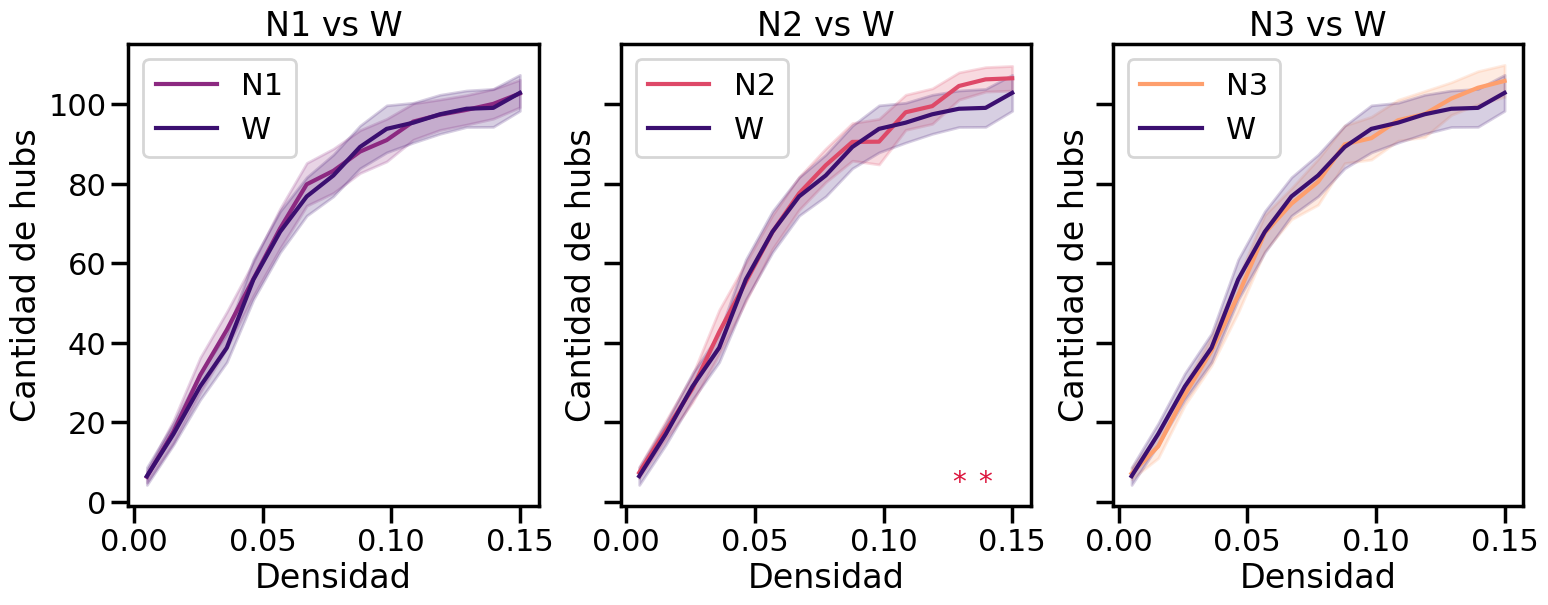

In [ ]:
# List of estados
estados = df.index.get_level_values('estado').unique()

# Group by index levels and calculate mean and standard error for each group
grouped = df.groupby(level=['estado', 'densidad']).agg({'Hub Count': ['mean', 'sem']}).reset_index()

# Create color palette
colors = sns.color_palette("magma", n_colors=4)

# Create subplots dynamically for each pair of N vs W
n_plots = len(estados) - 1  # Number of pairs (N vs W)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

# Iterate through each pair of N vs W starting from the second element
for i, estado in enumerate(estados[1:]):
    ax = axes[i]

    # Filter data for the current pair
    subset_N = grouped[grouped['estado'] == estado]
    subset_W = grouped[grouped['estado'] == 'W']

    # Perform Wilcoxon rank-sum test for each value of densidad
    p_values = []
    for densidad in df.index.get_level_values('densidad').unique():
        values_N = df[(df.index.get_level_values('estado') == estado) & (df.index.get_level_values('densidad') == densidad)]['Hub Count']
        values_W = df[(df.index.get_level_values('estado') == 'W') & (df.index.get_level_values('densidad') == densidad)]['Hub Count']

        # Perform Wilcoxon rank-sum test
        _, p_value = ranksums(values_N, values_W)
        p_values.append(p_value)

    # Print p-values
    print(f'{estado} vs W p-values: {", ".join(map(str, p_values))}')

    # Plot N vs W with color from the palette
    ax.plot(subset_N['densidad'], subset_N['Hub Count']['mean'], label=estado, color=colors[i+1])
    ax.fill_between(subset_N['densidad'], subset_N['Hub Count']['mean'] - 1.96*subset_N['Hub Count']['sem'], subset_N['Hub Count']['mean'] + 1.96*subset_N['Hub Count']['sem'], alpha=0.2, color=colors[i+1])

    ax.plot(subset_W['densidad'], subset_W['Hub Count']['mean'], label='W', color=colors[0])
    ax.fill_between(subset_W['densidad'], subset_W['Hub Count']['mean'] - 1.96*subset_W['Hub Count']['sem'], subset_W['Hub Count']['mean'] + 1.96*subset_W['Hub Count']['sem'], alpha=0.2, color=colors[0])

    # Find positions for asterisks
    sig_positions = [pos for pos, p_value in zip(subset_N['densidad'], p_values) if p_value < 0.05]

    # Add asterisks for 0.05 significance level inside the subplot area
    ymin, ymax = ax.get_ylim()
    for pos in sig_positions:
        ax.text(pos, ymin + 0.02 * (ymax - ymin), '*', ha='center', va='bottom', fontsize=20, color='crimson')

    # Add subtitle indicating the comparison
    ax.set_title(f'{estado} vs W')

    ax.set_xlabel('Densidad')
    ax.set_ylabel('Cantidad de hubs')
    ax.legend()

plt.savefig('hubs.png', bbox_inches = 'tight')
plt.show()


In [ ]:
# List of estados
estados = df.index.get_level_values('estado').unique()

# Group by index levels and calculate mean and standard error for each group
grouped = df.groupby(level=['estado', 'densidad']).agg({'Provincial Hub Count': ['mean', 'sem']}).reset_index()

# Create color palette
colors = sns.color_palette("magma", n_colors=4)

# Create subplots dynamically for each pair of N vs W
n_plots = len(estados) - 1  # Number of pairs (N vs W)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

# Iterate through each pair of N vs W starting from the second element
for i, estado in enumerate(estados[1:]):
    ax = axes[i]

    # Filter data for the current pair
    subset_N = grouped[grouped['estado'] == estado]
    subset_W = grouped[grouped['estado'] == 'W']

    # Perform Wilcoxon rank-sum test for each value of densidad
    p_values = []
    for densidad in df.index.get_level_values('densidad').unique():
        values_N = df[(df.index.get_level_values('estado') == estado) & (df.index.get_level_values('densidad') == densidad)]['Provincial Hub Count']
        values_W = df[(df.index.get_level_values('estado') == 'W') & (df.index.get_level_values('densidad') == densidad)]['Provincial Hub Count']

        # Perform Wilcoxon rank-sum test
        _, p_value = ranksums(values_N, values_W)
        p_values.append(p_value)

    # Print p-values
    print(f'{estado} vs W p-values: {", ".join(map(str, p_values))}')

    # Plot N vs W with color from the palette
    ax.plot(subset_N['densidad'], subset_N['Provincial Hub Count']['mean'], label=estado, color=colors[i+1])
    ax.fill_between(subset_N['densidad'], subset_N['Provincial Hub Count']['mean'] - 1.96*subset_N['Provincial Hub Count']['sem'], subset_N['Provincial Hub Count']['mean'] + 1.96*subset_N['Provincial Hub Count']['sem'], alpha=0.2, color=colors[i+1])

    ax.plot(subset_W['densidad'], subset_W['Provincial Hub Count']['mean'], label='W', color=colors[0])
    ax.fill_between(subset_W['densidad'], subset_W['Provincial Hub Count']['mean'] - 1.96*subset_W['Provincial Hub Count']['sem'], subset_W['Provincial Hub Count']['mean'] + 1.96*subset_W['Provincial Hub Count']['sem'], alpha=0.2, color=colors[0])

    # Add asterisks for 0.05 significance level
    for p_value in p_values:
        if p_value < 0.05:
            ax.text(0.5, max(ax.get_ylim()), '*', ha='center', va='bottom', fontsize=10, color='red')

    # Add subtitle indicating the comparison
    ax.set_title(f'{estado} vs W')

    ax.set_xlabel('Densidad')
    ax.set_ylabel('Cantidad de Provincial hubs')
    ax.legend()

plt.savefig('provincial_hubs.png', bbox_inches = 'tight')
plt.show()

In [ ]:
# List of estados
estados = df.index.get_level_values('estado').unique()

# Group by index levels and calculate mean and standard error for each group
grouped = df.groupby(level=['estado', 'densidad']).agg({'Provincial node Count': ['mean', 'sem']}).reset_index()

# Create color palette
colors = sns.color_palette("magma", n_colors=4)

# Create subplots dynamically for each pair of N vs W
n_plots = len(estados) - 1  # Number of pairs (N vs W)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

# Iterate through each pair of N vs W starting from the second element
for i, estado in enumerate(estados[1:]):
    ax = axes[i]

    # Filter data for the current pair
    subset_N = grouped[grouped['estado'] == estado]
    subset_W = grouped[grouped['estado'] == 'W']

    # Perform Wilcoxon rank-sum test for each value of densidad
    p_values = []
    for densidad in df.index.get_level_values('densidad').unique():
        values_N = df[(df.index.get_level_values('estado') == estado) & (df.index.get_level_values('densidad') == densidad)]['Provincial node Count']
        values_W = df[(df.index.get_level_values('estado') == 'W') & (df.index.get_level_values('densidad') == densidad)]['Provincial node Count']

        # Perform Wilcoxon rank-sum test
        _, p_value = ranksums(values_N, values_W)
        p_values.append(p_value)

    # Print p-values
    print(f'{estado} vs W p-values: {", ".join(map(str, p_values))}')

    # Plot N vs W with color from the palette
    ax.plot(subset_N['densidad'], subset_N['Provincial node Count']['mean'], label=estado, color=colors[i+1])
    ax.fill_between(subset_N['densidad'], subset_N['Provincial node Count']['mean'] - 1.96*subset_N['Provincial node Count']['sem'], subset_N['Provincial node Count']['mean'] + 1.96*subset_N['Provincial node Count']['sem'], alpha=0.2, color=colors[i+1])

    ax.plot(subset_W['densidad'], subset_W['Provincial node Count']['mean'], label='W', color=colors[0])
    ax.fill_between(subset_W['densidad'], subset_W['Provincial node Count']['mean'] - 1.96*subset_W['Provincial node Count']['sem'], subset_W['Provincial node Count']['mean'] + 1.96*subset_W['Provincial node Count']['sem'], alpha=0.2, color=colors[0])

    # Find positions for asterisks
    sig_positions = [pos for pos, p_value in zip(subset_N['densidad'], p_values) if p_value < 0.05]

    # Add asterisks for 0.05 significance level inside the subplot area
    ymin, ymax = ax.get_ylim()
    for pos in sig_positions:
        ax.text(pos, ymin + 0.02 * (ymax - ymin), '*', ha='center', va='bottom', fontsize=20, color='crimson')

    # Add subtitle indicating the comparison
    ax.set_title(f'{estado} vs W')

    ax.set_xlabel('Densidad')
    ax.set_ylabel('Cantidad de Provincial nodes')
    ax.legend()

plt.savefig('provincial_nodes.png', bbox_inches = 'tight')
plt.show()


In [ ]:
# List of estados
estados = df.index.get_level_values('estado').unique()

# Group by index levels and calculate mean and standard error for each group
grouped = df.groupby(level=['estado', 'densidad']).agg({'Connector node Count': ['mean', 'sem']}).reset_index()

# Create color palette
colors = sns.color_palette("magma", n_colors=4)

# Create subplots dynamically for each pair of N vs W
n_plots = len(estados) - 1  # Number of pairs (N vs W)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), sharey=True)

# Iterate through each pair of N vs W starting from the second element
for i, estado in enumerate(estados[1:]):
    ax = axes[i]

    # Filter data for the current pair
    subset_N = grouped[grouped['estado'] == estado]
    subset_W = grouped[grouped['estado'] == 'W']

    # Perform Wilcoxon rank-sum test for each value of densidad
    p_values = []
    for densidad in df.index.get_level_values('densidad').unique():
        values_N = df[(df.index.get_level_values('estado') == estado) & (df.index.get_level_values('densidad') == densidad)]['Connector node Count']
        values_W = df[(df.index.get_level_values('estado') == 'W') & (df.index.get_level_values('densidad') == densidad)]['Connector node Count']

        # Perform Wilcoxon rank-sum test
        _, p_value = ranksums(values_N, values_W)
        p_values.append(p_value)

    # Print p-values
    print(f'{estado} vs W p-values: {", ".join(map(str, p_values))}')

    # Plot N vs W with color from the palette
    ax.plot(subset_N['densidad'], subset_N['Connector node Count']['mean'], label=estado, color=colors[i+1])
    ax.fill_between(subset_N['densidad'], subset_N['Connector node Count']['mean'] - 1.96*subset_N['Connector node Count']['sem'], subset_N['Connector node Count']['mean'] + 1.96*subset_N['Connector node Count']['sem'], alpha=0.2, color=colors[i+1])

    ax.plot(subset_W['densidad'], subset_W['Connector node Count']['mean'], label='W', color=colors[0])
    ax.fill_between(subset_W['densidad'], subset_W['Connector node Count']['mean'] - 1.96*subset_W['Connector node Count']['sem'], subset_W['Connector node Count']['mean'] + 1.96*subset_W['Connector node Count']['sem'], alpha=0.2, color=colors[0])

    # Find positions for asterisks
    sig_positions = [pos for pos, p_value in zip(subset_N['densidad'], p_values) if p_value < 0.05]

    # Add asterisks for 0.05 significance level inside the subplot area
    ymin, ymax = ax.get_ylim()
    for pos in sig_positions:
        ax.text(pos, ymin + 0.02 * (ymax - ymin), '*', ha='center', va='bottom', fontsize=20, color='crimson')

    # Add subtitle indicating the comparison
    ax.set_title(f'{estado} vs W')

    ax.set_xlabel('Densidad')
    ax.set_ylabel('Cantidad de Connector nodes')
    ax.legend()

plt.savefig('connector_nodes.png', bbox_inches = 'tight')
plt.show()

##Nodos coloreados por tipo (malisimo pero puede servir de base para graficar)

In [ ]:
import networkx as nx
import pandas as pd

# Inicializar listas para almacenar los resultados
nodo_list = []
comunidad_list = []
grado_intramodular_list = []
desviacion_estandar_intramodular_list = []
z_score_intramodular_list = []
coeficiente_participacion_list = []
estado_list = []
densidad_list = []

# Calcular el grado intramodular y el coeficiente de participación para cada nodo en cada comunidad
for estado in estados:
    for densidad in densidades:
        if densidad != 0:
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G, random_state=42)
            nodos_comunidades = {comunidad: [] for comunidad in set(modulos.values())}

            for nodo, comunidad in modulos.items():
                nodos_comunidades[comunidad].append(nodo)

            for comunidad, nodos in nodos_comunidades.items():
                grados_nodos_comunidad = [G.degree(nodo) for nodo in nodos]
                grado_promedio_intramodular = sum(grados_nodos_comunidad) / len(grados_nodos_comunidad)
                desviacion_estandar = pd.Series(grados_nodos_comunidad).std()

                # Manejar el caso cuando la desviación estándar es NaN
                if pd.isna(desviacion_estandar):
                    desviacion_estandar = 0.0

                for nodo in nodos:
                    grado_nodo = G.degree(nodo)
                    grado_intramodular = grado_nodo / grado_promedio_intramodular if grado_promedio_intramodular != 0 else 0.0
                    z_score = (grado_nodo - grado_promedio_intramodular) / desviacion_estandar if desviacion_estandar != 0 else 0.0

                    # Calcular el coeficiente de participación
                    grado_total_nodo = sum(G.degree(n) for n in G.neighbors(nodo))  # Sumar los grados de todos los nodos vecinos
                    coeficiente_participacion = 1 - (grado_nodo / grado_total_nodo)**2 if grado_total_nodo != 0 else 0.0

                    nodo_list.append(nodo)
                    comunidad_list.append(comunidad)
                    grado_intramodular_list.append(grado_intramodular)
                    desviacion_estandar_intramodular_list.append(desviacion_estandar)
                    z_score_intramodular_list.append(z_score)
                    coeficiente_participacion_list.append(coeficiente_participacion)
                    estado_list.append(estado)
                    densidad_list.append(densidad)

# Crear un DataFrame con los resultados
resultados_df = pd.DataFrame({
    'Nodo': nodo_list,
    'Comunidad': comunidad_list,
    'Grado_Intramodular': grado_intramodular_list,
    'Desviacion_Estandar_Intramodular': desviacion_estandar_intramodular_list,
    'Z_Score_Intramodular': z_score_intramodular_list,
    'Coeficiente_Participacion': coeficiente_participacion_list,
    'Estado': estado_list,
    'Densidad': densidad_list
})

# Visualizar el DataFrame con los resultados
print(resultados_df)

In [ ]:
# Definir umbrales para clasificación
umbral_coeficiente_participacion = 0.05
umbral_z_score = 1.0

# Clasificar nodos según las condiciones dadas
#resultados_df['Clasificacion'] = 'No Clasificado'  # Inicializar columna de clasificación

# Hubs
resultados_df.loc[(resultados_df['Coeficiente_Participacion'] > umbral_coeficiente_participacion) &
                   (resultados_df['Z_Score_Intramodular'] > umbral_z_score), 'Clasificacion'] = 'Hubs'

# Provincial Hubs
resultados_df.loc[(resultados_df['Coeficiente_Participacion'] < umbral_coeficiente_participacion) &
                   (resultados_df['Z_Score_Intramodular'] > umbral_z_score), 'Clasificacion'] = 'Provincial Hubs'

# Provincial Nodes
resultados_df.loc[(resultados_df['Coeficiente_Participacion'] < umbral_coeficiente_participacion) &
                   (resultados_df['Z_Score_Intramodular'] < umbral_z_score), 'Clasificacion'] = 'Provincial Nodes'

# Connector Nodes
resultados_df.loc[(resultados_df['Coeficiente_Participacion'] > umbral_coeficiente_participacion) &
                   (resultados_df['Z_Score_Intramodular'] < umbral_z_score), 'Clasificacion'] = 'Connector Nodes'

# Visualizar el DataFrame con la nueva columna de clasificación
print(resultados_df)


In [ ]:
resultados_df[resultados_df['Densidad']==0.08][['Clasificacion', 'Estado']].value_counts()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib import cm

# Crear un mapeo de colores para las categorías de clasificación
color_map = {
    'Hubs': 'red',
    'Provincial Hubs': 'blue',
    'Provincial Nodes': 'green',
    'Connector Nodes': 'orange',
    'No Clasificado': 'gray'  # Puedes ajustar esto según tus necesidades
}

# Configurar la figura y los ejes
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.82})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

# Conjunto para almacenar clasificaciones únicas
unique_classifications = set()

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), 0.08)

    # Obtener clasificaciones y asignar colores según el color_map
    clasificaciones = resultados_df[(resultados_df['Densidad'] == densidad) & (resultados_df['Estado'] == estado)]['Clasificacion']
    node_colors = clasificaciones.map(color_map)

    # Actualizar el conjunto de clasificaciones únicas
    unique_classifications.update(clasificaciones.unique())

    # Dibujar nodos
    nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, node_color=node_colors)

    # Dibujar bordes
    nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='gray')

    ax[n].set_title(f'Estado {estado}', fontsize=12)
    ax[n].axis('off')

# Crear elementos de leyenda únicos
legend_elements = [Line2D([0], [0], marker='o', color=color_map[clasificacion], markersize=10, label=clasificacion) for clasificacion in unique_classifications]

# Dibujar custom legend con posición horizontal debajo de los subplots
fig.legend(handles=legend_elements, loc='lower center', ncol=len(unique_classifications), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.95, 0.8])  # Ajustar el rectángulo para dejar espacio para la leyenda

# Mostrar la figura
plt.suptitle(f'Nodos coloreados según su clasificación para densidad = {densidad}', size=16)
plt.show()

## A este si le confio mas, porque se basa en una libreria y porque hay provincial hubs!! Creo que este es el camino para el primer punto. Capaz que corrigiendo levemente el codigo de flor por los calculos que ya estan definidos en la libreria ada!

In [9]:
pip install git+https://github.com/fiuneuro/brainconn.git

  Cloning https://github.com/fiuneuro/brainconn.git to c:\users\joses\appdata\local\temp\pip-req-build-04an3z2g
  Resolved https://github.com/fiuneuro/brainconn.git to commit 8cd436a885c9f823ef7789aa032cc2119318ff59
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for brainconn: filename=brainconn-0.0.1-py3-none-any.whl size=109877 sha256=0645fabac373e705342f1b773b73d9517a6ca67b9ca77563fbb05950d3b80a77
  Stored in directory: C:\Users\joses\AppData\Local\Temp\pip-ephem-wheel-cache-c7eqjl4n\wheels\83\ae\09\0f5f14fa902eedd87c3ce8ecadf2f854abaa3b661512ba5f30
Successfully built brainconn
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/fiuneuro/brainconn.git 'C:\Users\joses\AppData\Local\Temp\pip-req-build-04an3z2g'

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import brainconn

Failed to import duecredit due to No module named 'duecredit'


In [ ]:
#Funcion para que me de la matriz_promedio_no_pesada
def matriz_promedio_no_pesada_densidad(matriz,densidad):
  matriz_promedio_no_pesada = matriz>=density_to_th(matriz,densidad)
  return matriz_promedio_no_pesada

In [ ]:
import pandas as pd
import numpy as np
import warnings

with warnings.catch_warnings():
    # Bloque de código donde se suprimen las advertencias
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Lista de estados y valores de densidad
    estados = ['W', 'N1', 'N2', 'N3']
    densidades = np.arange(0.01, 0.16, 0.01)

    # Inicializar una lista para almacenar los resultados de cada combinación
    resultados_totales = []

    # Iterar sobre estados y densidades
    for estado in estados:
        for densidad in densidades:
            # Calcular el grafo y los módulos usando networkx
            G = grafo_densidad(matriz_promedio(estado), densidad)
            modulos = cl.best_partition(G, random_state=42)

            # Calcular la centralidad de grado z-score y el coeficiente de participación utilizando la libreria brainconn para eso necesita la matriz_promedio_no_pesada y los modulos como array
            module_degree_zscore = brainconn.centrality.module_degree_zscore(
                matriz_promedio_no_pesada_densidad(matriz_promedio(estado), densidad),
                np.array(list(modulos.values()))
            )
            participation_coef = brainconn.centrality.participation_coef(
                matriz_promedio_no_pesada_densidad(matriz_promedio(estado), densidad),
                np.array(list(modulos.values()))
            )

            # Obtener nodos y módulos
            nodos = list(modulos.keys())
            modulos_lista = list(modulos.values())

            # Crear un DataFrame con los resultados
            df_resultados = pd.DataFrame({
                'Nodo': nodos,
                'Modulo': modulos_lista,
                'Module_Degree_ZScore': module_degree_zscore,
                'Participation_Coefficient': participation_coef
            })

            # Agregar información adicional, como estado y densidad
            df_resultados['Estado'] = estado
            df_resultados['Densidad'] = densidad

            # Agregar el DataFrame a la lista de resultados totales
            resultados_totales.append(df_resultados)

    # Combinar todos los resultados en un solo DataFrame
    df_final = pd.concat(resultados_totales, ignore_index=True)

    # Visualizar el DataFrame final
    print(df_final)


In [ ]:
# Definir umbrales para clasificación
umbral_module_degree_zscore = 1.0
umbral_participation_coef = 0.05

# Inicializar columna de clasificación
df_final['Clasificacion'] = 'No Clasificado'

# Hubs
df_final.loc[(df_final['Participation_Coefficient'] >= umbral_participation_coef) &
                  (df_final['Module_Degree_ZScore'] >= umbral_module_degree_zscore), 'Clasificacion'] = 'Hubs'

# Provincial Hubs
df_final.loc[(df_final['Participation_Coefficient'] < umbral_participation_coef) &
                  (df_final['Module_Degree_ZScore'] >= umbral_module_degree_zscore), 'Clasificacion'] = 'Provincial Hubs'

# Provincial Nodes
df_final.loc[(df_final['Participation_Coefficient'] < umbral_participation_coef) &
                  (df_final['Module_Degree_ZScore'] < umbral_module_degree_zscore), 'Clasificacion'] = 'Provincial Nodes'

# Connector Nodes
df_final.loc[(df_final['Participation_Coefficient'] >= umbral_participation_coef) &
                  (df_final['Module_Degree_ZScore'] < umbral_module_degree_zscore), 'Clasificacion'] = 'Connector Nodes'

In [ ]:
df_final[(df_final['Densidad']==0.08)][['Clasificacion', 'Estado']].value_counts()

In [ ]:
#Podemos tomar una decision para ver que hacer aca, si tomar >=1 o <=1, que sea =1 no lo clasifica
#df_final[(df_final['Module_Degree_ZScore']==1) & (df_final['Densidad']==0.08)]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la densidad deseada
df_densidad_08 = df_final[df_final['Densidad'] == 0.08]

# Excluir la clasificación "No Clasificado"
df_densidad_08 = df_densidad_08[df_densidad_08['Clasificacion'] != 'No Clasificado']

# Obtener las clasificaciones únicas
clasificaciones_unicas = df_densidad_08['Clasificacion'].unique()

# Configurar el diseño de los subplots
num_clasificaciones = len(clasificaciones_unicas)
num_subplots_por_fila = 2  # Dos subplots por fila
num_filas = (num_clasificaciones + num_subplots_por_fila - 1) // num_subplots_por_fila
fig, axs = plt.subplots(num_filas, num_subplots_por_fila, figsize=(15, 6 * num_filas), sharey=False)

# Asegurarse de que axs sea un array 2D, incluso si num_filas es 1
if num_filas == 1:
    axs = axs.reshape(1, -1)

# Iterar sobre cada clasificación y crear un subplot
for i, clasificacion in enumerate(clasificaciones_unicas):
    fila_actual = i // num_subplots_por_fila
    col_actual = i % num_subplots_por_fila

    df_clasificacion = df_densidad_08[df_densidad_08['Clasificacion'] == clasificacion]

    # Crear un gráfico de barras para cada clasificación
    sns.countplot(x='Estado', data=df_clasificacion, ax=axs[fila_actual, col_actual], palette='viridis')

    # Añadir etiquetas y título para cada subplot
    axs[fila_actual, col_actual].set_title(f'Histograma de {clasificacion}', size=14)
    axs[fila_actual, col_actual].tick_params(axis='both', which='both', length=6, width=1, labelsize=12)
    axs[fila_actual, col_actual].set_xlabel('Estado', size = 12)
    axs[fila_actual, col_actual].set_ylabel('Cantidad', size = 12)

# Ajustar el diseño
#plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(top=0.92)
plt.suptitle(f'Roles de nodos según su partición para densidad = 0.08', size=16)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib import cm

# Crear un mapeo de colores para las categorías de clasificación
color_map = {
    'Hubs': 'red',
    'Provincial Hubs': 'blue',
    'Provincial Nodes': 'green',
    'Connector Nodes': 'orange',
    'No Clasificado': 'gray'  # Puedes ajustar esto según tus necesidades
}

# Configurar la figura y los ejes
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.82})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

# Conjunto para almacenar clasificaciones únicas
unique_classifications = set()

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), 0.08)

    # Obtener clasificaciones y asignar colores según el color_map
    clasificaciones = df_final[(df_final['Densidad'] == densidad) & (df_final['Estado'] == estado)]['Clasificacion']
    node_colors = clasificaciones.map(color_map)

    # Actualizar el conjunto de clasificaciones únicas
    unique_classifications.update(clasificaciones.unique())

    # Dibujar nodos
    nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, node_color=node_colors)

    # Dibujar bordes
    nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='gray')

    ax[n].set_title(f'Estado {estado}', fontsize=12)
    ax[n].axis('off')

# Crear elementos de leyenda únicos
legend_elements = [Line2D([0], [0], marker='o', color=color_map[clasificacion], markersize=10, label=clasificacion) for clasificacion in unique_classifications]

# Dibujar custom legend con posición horizontal debajo de los subplots
fig.legend(handles=legend_elements, loc='lower center', ncol=len(unique_classifications), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.95, 0.8])  # Ajustar el rectángulo para dejar espacio para la leyenda

# Mostrar la figura
plt.suptitle(f'Nodos coloreados según su rol para densidad = {densidad}', size=16)
plt.show()

## Otra opcion Opcional 3

Defino una nueva nueva funcion pero para que me devuelva la matriz pesada individual

In [27]:
def matrices_individuales(sujeto):
    n = 116
    matAdyacPesada = np.zeros((n,n))

    # Leer la matriz del archivo y asegurarse de que sea cuadrada
    matAdyacPesada = pd.read_csv('DataSujetos/' + sujeto, header=None).values
    np.fill_diagonal(matAdyacPesada, 0) #0 en la diagonal para que no genere autoenlaces

        # Agregar la matriz a la lista
    #    matrices.append(matriz)
    return matAdyacPesada

Es la misma de mas arriba

In [6]:
def density_to_th(W, d):
    n = W.shape[0]
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c) - 1) * d)]

Para calcular el grafo, pero de la matriz individual

In [5]:
def grafo_densidad_individual(matriz, densidad):
    # Aplicar la función density_to_th y obtener la matriz_no_pesada
    matriz_no_pesada = matriz >= density_to_th(matriz, densidad)

    # Asegurar ceros en la diagonal
    np.fill_diagonal(matriz_no_pesada, 0)

    # Crear el grafo a partir de la matriz_no_pesada
    G = nx.from_numpy_array(matriz_no_pesada)
    return G

Para obtener la matriz no pesada individual

In [4]:
def matriz_individual_no_pesada_densidad(matriz, densidad):
    # Aplicar la función density_to_th y obtener la matriz_no_pesada
    matriz_no_pesada = matriz >= density_to_th(matriz, densidad)

    # Asegurar ceros en la diagonal
    np.fill_diagonal(matriz_no_pesada, 0)

    return matriz_no_pesada

Acá es donde hay que corregir para itere bien por sujetos..me parece que no lo esta haciendo bien por el numero de filas que me esta dando.

In [47]:
import pandas as pd
import numpy as np
import warnings

with warnings.catch_warnings():
    # Bloque de código donde se suprimen las advertencias
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Lista de estados, valores de densidad y sujetos
    estados = ['W', 'N1', 'N2', 'N3']
    densidades = np.arange(0.01, 0.16, 0.01)

    # Inicializar una lista para almacenar los resultados de cada combinación
    resultados_totales = []

    # Iterar sobre estados, densidades y sujetos
    for estado in estados:
        for densidad in densidades:
            for sujeto in sujetos[sujetos.index.str.contains(estado)].index:
                print("Estado: ",estado," Densidad: ",densidad," Sujeto: ",sujeto,end='\r')
                # Calcular el grafo y los módulos usando networkx
                matriz = matrices_individuales(sujeto)
                G = grafo_densidad_individual(matriz, densidad)
                modulos = cl.best_partition(G, random_state=42)
                matriz_no_pesada = matriz_individual_no_pesada_densidad(matriz, densidad)
                
                
                # Calcular la centralidad de grado z-score y el coeficiente de participación utilizando la libreria brainconn
                module_degree_zscore = brainconn.centrality.module_degree_zscore(matriz_no_pesada,np.array(list(modulos.values())))
                participation_coef = brainconn.centrality.participation_coef(matriz_no_pesada,np.array(list(modulos.values())))

                # Obtener nodos y módulos
                nodos = list(modulos.keys())
                modulos_lista = list(modulos.values())

                # Crear un DataFrame con los resultados
                df_resultados = pd.DataFrame({
                    'Nodo': nodos,
                    'Modulo': modulos_lista,
                    'Module_Degree_ZScore': module_degree_zscore,
                    'Participation_Coefficient': participation_coef,
                    'Sujeto': sujeto,
                    'Estado': estado,
                    'Densidad': densidad
                })

                # Agregar el DataFrame a la lista de resultados totales
                resultados_totales.append(df_resultados)

    # Combinar todos los resultados en un solo DataFrame
    df_final_sujeto = pd.concat(resultados_totales, ignore_index=True)

    # Visualizar el DataFrame final
    print(df_final_sujeto)


        Nodo  Modulo  Module_Degree_ZScore  Participation_Coefficient  \
0          0       0             -0.707107                       0.00   
1          1       1              0.000000                       0.00   
2          2       2             -0.707107                       0.00   
3          3       3             -0.196116                       0.00   
4          4       4              0.000000                       0.00   
...      ...     ...                   ...                        ...   
125275   111      17             -0.548821                       0.50   
125276   112       3             -1.650274                       0.32   
125277   113      18              0.000000                       0.00   
125278   114       2              0.000000                       0.00   
125279   115      11              0.000000                       0.00   

             Sujeto Estado  Densidad  
0        W_suj1.csv      W      0.01  
1        W_suj1.csv      W      0.01  
2     

Dps seria simplemente aplicar la clasificacion para tener heho

In [32]:
# Definir umbrales para clasificación
umbral_module_degree_zscore = 1.0
umbral_participation_coef = 0.05

# Inicializar columna de clasificación
df_final_sujeto['Clasificacion'] = 'No Clasificado'

part_coef_mayor = (df_final_sujeto['Participation_Coefficient'] > umbral_participation_coef)
module_deg_mayor = (df_final_sujeto['Module_Degree_ZScore'] > umbral_module_degree_zscore)
# Hubs
df_final_sujeto.loc[part_coef_mayor & module_deg_mayor, 'Clasificacion'] = 'Hubs'

# Provincial Hubs
df_final_sujeto.loc[~part_coef_mayor & module_deg_mayor, 'Clasificacion'] = 'Provincial Hubs'

# Provincial Nodes
df_final_sujeto.loc[~part_coef_mayor & ~module_deg_mayor, 'Clasificacion'] = 'Provincial Nodes'

# Connector Nodes
df_final_sujeto.loc[part_coef_mayor & ~module_deg_mayor, 'Clasificacion'] = 'Connector Nodes'

In [ ]:
df_final_sujeto.to_pickle('df_final_sujeto_JSG.pkl')

In [30]:
df_final_sujeto = pd.read_pickle('df_final_sujeto_JSG.pkl')

In [33]:
df_final_sujeto.Clasificacion.value_counts()

Clasificacion
Provincial Nodes    63469
Connector Nodes     44821
Hubs                10919
Provincial Hubs      6071
Name: count, dtype: int64

ValueError: 'c' argument has 2088 elements, which is inconsistent with 'x' and 'y' with size 116.

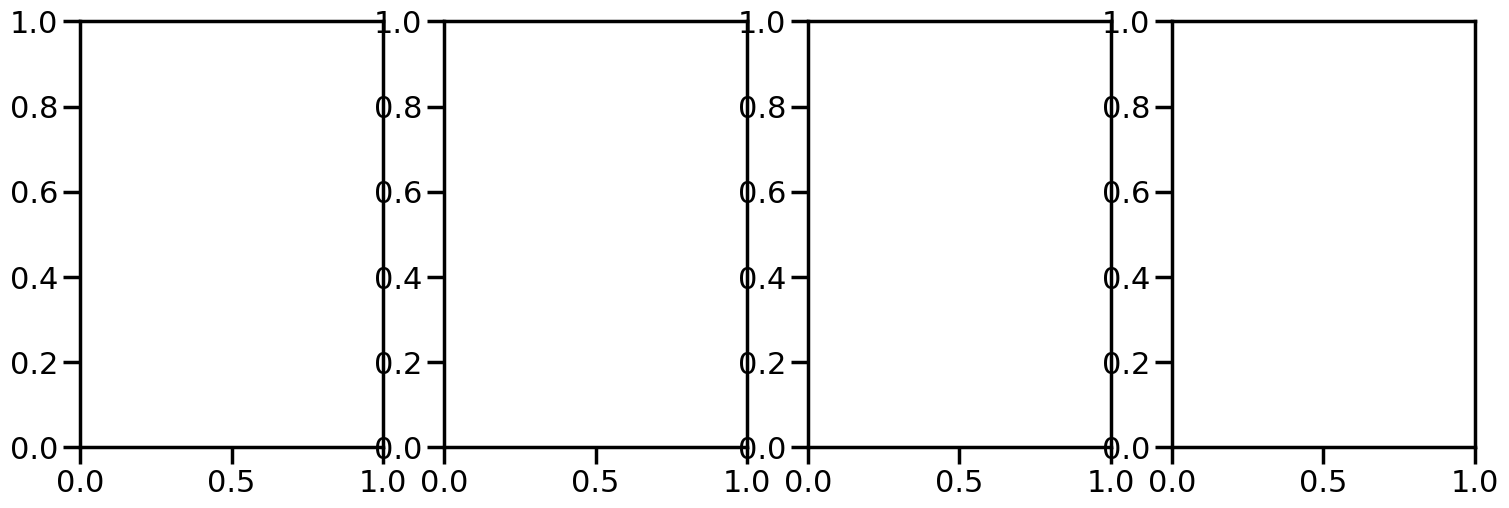

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
from matplotlib import cm
import numpy as np

estados = ['W','N1','N2','N3']
# Crear un mapeo de colores para las categorías de clasificación
color_map = {
    'Hubs': 'red',
    'Provincial Hubs': 'blue',
    'Provincial Nodes': 'green',
    'Connector Nodes': 'orange',
    'No Clasificado': 'gray'  # Puedes ajustar esto según tus necesidades
}

# Configurar la figura y los ejes
fig, ax = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'top': 0.82})
layout = dict(zip(range(116), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

densidad = 0.08

# Conjunto para almacenar clasificaciones únicas
unique_classifications = set()

for n, estado in enumerate(estados):
    G = grafo_densidad(matriz_promedio(estado), 0.08)

    # Obtener clasificaciones y asignar colores según el color_map
    clasificaciones = df_final_sujeto[(df_final_sujeto['Densidad'] == densidad) & (df_final_sujeto['Estado'] == estado)]['Clasificacion']
    node_colors = clasificaciones.map(color_map)

    # Actualizar el conjunto de clasificaciones únicas
    unique_classifications.update(clasificaciones.unique())

    # Dibujar nodos
    nx.draw_networkx_nodes(G, layout, ax=ax[n], node_size=40, node_color=node_colors)

    # Dibujar bordes
    nx.draw_networkx_edges(G, layout, ax=ax[n], alpha=0.5, edge_color='gray')

    ax[n].set_title(f'Estado {estado}', fontsize=12)
    ax[n].axis('off')

# Crear elementos de leyenda únicos
legend_elements = [Line2D([0], [0], marker='o', color=color_map[clasificacion], markersize=10, label=clasificacion) for clasificacion in unique_classifications]

# Dibujar custom legend con posición horizontal debajo de los subplots
fig.legend(handles=legend_elements, loc='lower center', ncol=len(unique_classifications), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.95, 0.8])  # Ajustar el rectángulo para dejar espacio para la leyenda

# Mostrar la figura
plt.suptitle(f'Nodos coloreados según su rol para densidad = {densidad}', size=16)
plt.show()

C:\Users\joses\AppData\Local\Temp\ipykernel_20540\588634087.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Estado', data=df_clasificacion, ax=axs[fila_actual, col_actual], palette='viridis')
C:\Users\joses\AppData\Local\Temp\ipykernel_20540\588634087.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Estado', data=df_clasificacion, ax=axs[fila_actual, col_actual], palette='viridis')
C:\Users\joses\AppData\Local\Temp\ipykernel_20540\588634087.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Estado', data=df_clasific

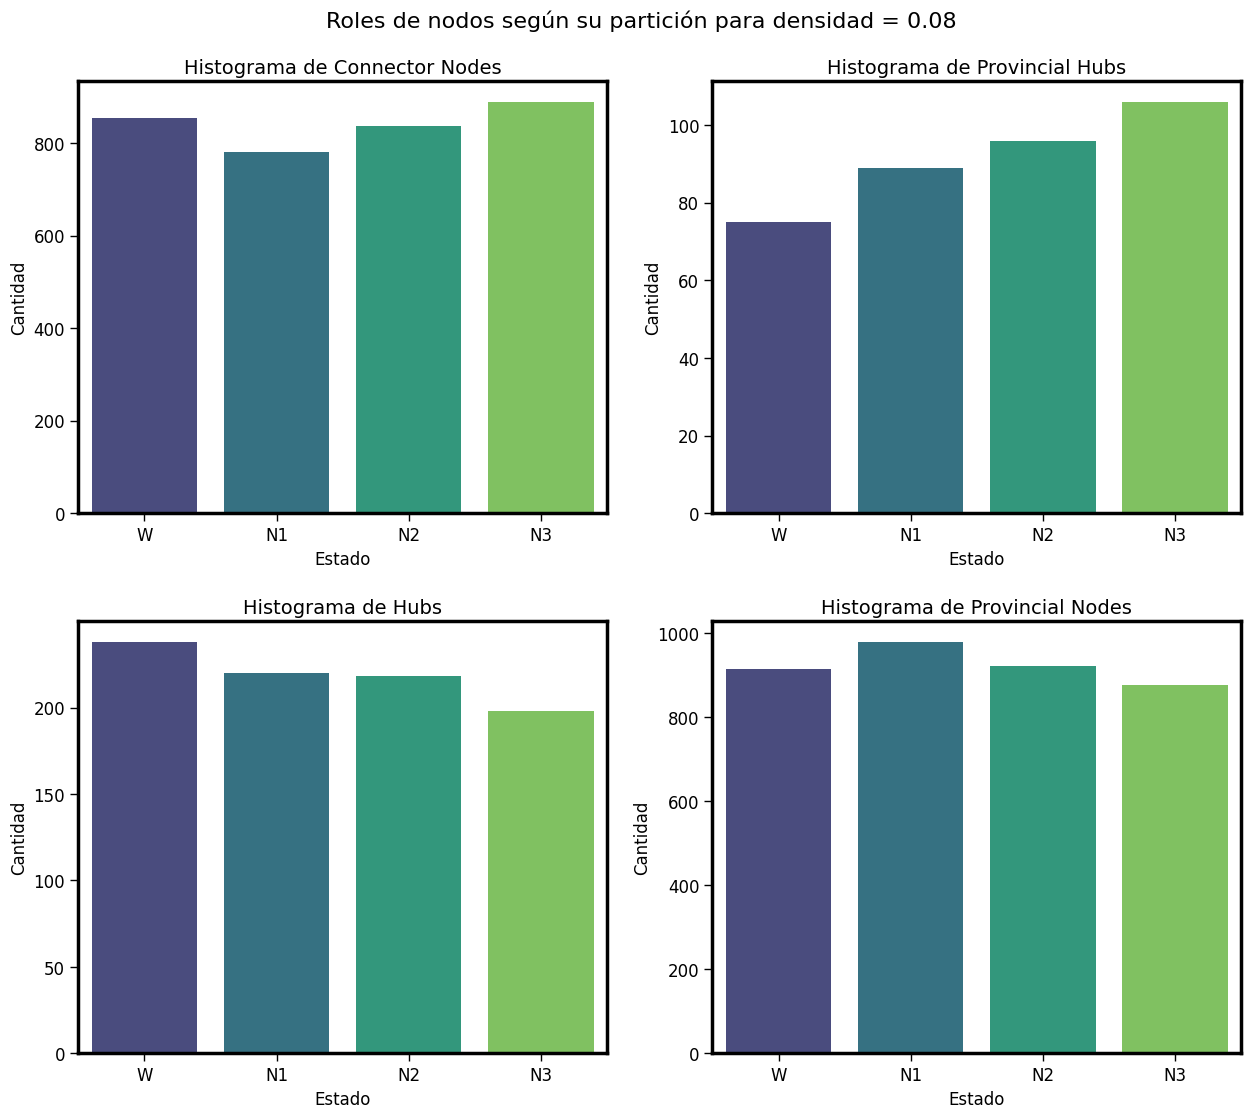

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar los datos para la densidad deseada
df_densidad_08 = df_final_sujeto[df_final_sujeto['Densidad'] == 0.08]

# Excluir la clasificación "No Clasificado"
df_densidad_08 = df_densidad_08[df_densidad_08['Clasificacion'] != 'No Clasificado']

# Obtener las clasificaciones únicas
clasificaciones_unicas = df_densidad_08['Clasificacion'].unique()

# Configurar el diseño de los subplots
num_clasificaciones = len(clasificaciones_unicas)
num_subplots_por_fila = 2  # Dos subplots por fila
num_filas = (num_clasificaciones + num_subplots_por_fila - 1) // num_subplots_por_fila
fig, axs = plt.subplots(num_filas, num_subplots_por_fila, figsize=(15, 6 * num_filas), sharey=False)

# Asegurarse de que axs sea un array 2D, incluso si num_filas es 1
if num_filas == 1:
    axs = axs.reshape(1, -1)

# Iterar sobre cada clasificación y crear un subplot
for i, clasificacion in enumerate(clasificaciones_unicas):
    fila_actual = i // num_subplots_por_fila
    col_actual = i % num_subplots_por_fila

    df_clasificacion = df_densidad_08[df_densidad_08['Clasificacion'] == clasificacion]

    # Crear un gráfico de barras para cada clasificación
    sns.countplot(x='Estado', data=df_clasificacion, ax=axs[fila_actual, col_actual], palette='viridis')

    # Añadir etiquetas y título para cada subplot
    axs[fila_actual, col_actual].set_title(f'Histograma de {clasificacion}', size=14)
    axs[fila_actual, col_actual].tick_params(axis='both', which='both', length=6, width=1, labelsize=12)
    axs[fila_actual, col_actual].set_xlabel('Estado', size = 12)
    axs[fila_actual, col_actual].set_ylabel('Cantidad', size = 12)

# Ajustar el diseño
#plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(top=0.92)
plt.suptitle(f'Roles de nodos según su partición para densidad = 0.08', size=16)
plt.show()
